In [2]:
# Core imports
import os
from datetime import datetime
import math
import hashlib
import gc

# Data and computation libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Image processing and visualization
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow/Keras imports
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
from keras.metrics import MeanIoU
from keras.saving import register_keras_serializable
from tensorflow.keras import layers as tfkl

# Augmentation libraries
import albumentations as A
from albumentations import Compose
from albumentations.augmentations.transforms import *
from albumentations.core.composition import OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform

# Configurations
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

# Set random seeds
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Install for augmentation

!pip install albumentations opencv-python

# Utilities

In [28]:
# For plotting and inspecting pairs of images and masks

def plot_image_mask_pairs(X, y, num_pairs=5):
    num_samples = min(num_pairs, len(X))
    plt.figure(figsize=(10, 4 * num_samples))

    random_indices = np.random.choice(len(X), num_samples, replace=False)
    for idx, i in enumerate(random_indices):
        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(y[i], cmap='nipy_spectral', vmin=0, vmax=4)  # Standardize the color scaling
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_image_mask_pairs_specific_indices(X, y, indices, num_samples=10):
    plt.figure(figsize=(10, 4 * num_samples))

    for idx, i in enumerate(indices):
        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(y[i], cmap='nipy_spectral', vmin=0, vmax=4)
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
# To isolate images that have the same mask (used for finding the alien-images)

def find_duplicate_masks(labels):
    hashes = {}
    duplicates = {}

    for i, mask in enumerate(labels):
        mask_flat = mask.tobytes()
        mask_hash = hashlib.md5(mask_flat).hexdigest()

        if mask_hash in hashes:
            first_index = hashes[mask_hash]
            if first_index not in duplicates:
                duplicates[first_index] = []  # Initialize the list for this first index
            duplicates[first_index].append(i)  # Add the duplicate index
        else:
            hashes[mask_hash] = i  # Store the first occurrence of this hash

    return duplicates

In [6]:
def remove_alien_elements(input_dict, keys_to_remove):
    result = {}
    for key, value in input_dict.items():
        if key not in keys_to_remove:
            result[key] = value
    return result

In [7]:
# For removing certain images and masks from NumPy arrays

def remove_indices(X, y, indices_to_keep):
  images_keep = []
  masks_keep = []
  images_discard = []
  masks_discard = []

  for idx in range (0, len(X)):
    if idx in indices_to_keep:
      images_keep.append(X[idx])
      masks_keep.append(y[idx])
    else:
      images_discard.append(X[idx])
      masks_discard.append(y[idx])

  images_discard = np.array(images_discard)
  masks_discard = np.array(masks_discard)
  images_keep = np.array(images_keep)
  masks_keep = np.array(masks_keep)

  return images_keep, masks_keep, images_discard, masks_discard

def remove_indices_negative(X, y, indices_to_remove):
  images_keep = []
  masks_keep = []
  images_discard = []
  masks_discard = []

  for idx in range (0, len(X)):
    if idx in indices_to_remove:
      images_discard.append(X[idx])
      masks_discard.append(y[idx])
    else:
      images_keep.append(X[idx])
      masks_keep.append(y[idx])

  images_discard = np.array(images_discard)
  masks_discard = np.array(masks_discard)
  images_keep = np.array(images_keep)
  masks_keep = np.array(masks_keep)

  return images_keep, masks_keep, images_discard, masks_discard

In [8]:
# For calculating class weights based on class distribution in training masks

def compute_class_weights(train_masks, num_classes=5):
    # Initialize counts for each class
    pixel_counts = np.zeros(num_classes, dtype=np.int64)

    # Count pixels per class
    for mask in train_masks:
        for cls in range(num_classes):
            pixel_counts[cls] += np.sum(mask == cls)

    # Compute class weights using inverse frequency
    total_pixels = np.sum(pixel_counts)
    class_weights = total_pixels / (num_classes * pixel_counts)

    return pixel_counts, class_weights

In [9]:
# Helper functions for plotting

def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):

    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Loading and cleaning the data

In [10]:
# Data loading functionality

data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X = training_set[:, 0]
y = training_set[:, 1]

X_test = data["test_set"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Test X shape: {X_test.shape}")

X shape: (2615, 64, 128)
y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [11]:
# Removing alien images

duplicates = find_duplicate_masks(y)

#After manual inspection, the first alien image appears at index 62:
alien_image_indices = duplicates[62]
alien_image_indices.append(62)

X_train = np.delete(X, alien_image_indices, axis=0)
y_train = np.delete(y, alien_image_indices, axis=0)

In [12]:
print(f"Alien-free X shape: {X_train.shape}")
print(f"Alien-free y shape: {y_train.shape}")

Alien-free X shape: (2505, 64, 128)
Alien-free y shape: (2505, 64, 128)


# Attempting to improve masks (not used for final model)

Goal:

In many images, there’s too much black (unclassified/background). Some areas, like sand, are segmented correctly, but there are gaps or inconsistencies in the segmentation for no clear reason. These gaps often occur even though the pixels at the edges of these segmentation blobs don’t differ significantly. The idea is to “smooth out” these blobs by allowing the segmentation to expand into nearby background areas, provided the pixel differences in those areas are small.

Proposed Algorithm:
1. Start from a segmented region (a blob) that is not classified as 0 (background).
2. Check if the entire image is already segmented into the same class:
* If yes: Do nothing.
* If no: Proceed to the next steps.
3. For each point in the blob:
* Search for a point where a circle (size to be decided) around it contains a border of the segmentation blob.
4. When you find such a point:
* Calculate the pixel intensity difference (darkest vs. brightest) within the circle.
5. If this intensity difference is below a certain threshold (to be decided):
* Expand the segmentation by assigning the same class as the center point to all pixels in the circle.
6. Repeat the process:
* Keep searching for new points and expanding the blob outward where applicable.
* Stop if no valid points are found after 100 attempts.


In [13]:
def refine_segmentation_mask(image, mask, radius=4, threshold=10, max_attempts=100):
    def get_circle_indices(x, y, radius, shape):
        indices = []
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                if i**2 + j**2 <= radius**2:  # Check if the point is within the circle
                    new_x, new_y = x + i, y + j
                    if 0 <= new_x < shape[0] and 0 <= new_y < shape[1]:
                        indices.append((new_x, new_y))
        return indices
    refined_mask = mask.copy()
    attempts = 0

    while attempts < max_attempts:
        attempts += 1
        expanded = False

        # Find points on the border of blobs
        for x in range(mask.shape[0]):
            for y in range(mask.shape[1]):
                if refined_mask[x, y] == 0:  # Skip background pixels
                    continue

                # Check if the point is on the border of a blob
                circle_indices = get_circle_indices(x, y, radius, mask.shape)
                border_found = any(refined_mask[i, j] == 0 for i, j in circle_indices)

                if not border_found:
                    continue

                # Calculate pixel value range within the circle
                pixel_values = [image[i, j] for i, j in circle_indices]
                pixel_range = max(pixel_values) - min(pixel_values)

                if pixel_range <= threshold:
                    for i, j in circle_indices:
                        if refined_mask[i, j] == 0:  # Only expand into background
                            refined_mask[i, j] = refined_mask[x, y]
                            expanded = True
        if not expanded:
            break
    return refined_mask

In [15]:
print(y_train.shape)

(2505, 64, 128)


In [16]:
images = X_train
masks = y_train

The image and corresponding mask before the mask has been filled out


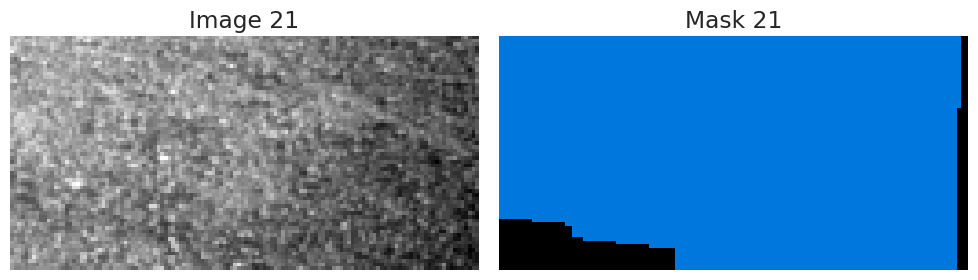

In [58]:
# Before mask has been filled out

print("The image and corresponding mask before the mask has been filled out")

plot_image_mask_pairs_specific_indices(images, masks, [20], 1)

In [51]:
refined_masks = []

for i in range (0, len(images)):
  image = images[i]
  mask = masks[i]
  refined_mask = refine_segmentation_mask(image, mask)
  refined_masks.append(refined_mask)

refined_masks_array = np.array(refined_masks)


The image and corresponding mask after the mask has been filled out


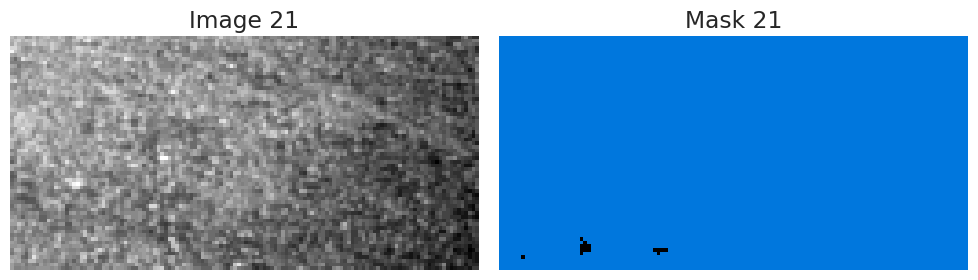

In [59]:
# After the mask has been filled out

print("The image and corresponding mask after the mask has been filled out")

plot_image_mask_pairs_specific_indices(images, refined_masks_array, [20], 1)

# Train/Validation splitting and image augmentation

In [60]:
test_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=seed)

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2004, 64, 128)
(2004, 64, 128)
(501, 64, 128)
(501, 64, 128)


In [62]:
# Definitions of functions for image augmentation

def flip_dataset(X_train, y_train):
    # Horizontal flipping
    X_h_flip = np.flip(X_train, axis=2)  # Flip along width (horizontal axis)
    y_h_flip = np.flip(y_train, axis=2)

    # Combine original and horizontally flipped data
    X_combined = np.concatenate((X_train, X_h_flip), axis=0)
    y_combined = np.concatenate((y_train, y_h_flip), axis=0)

    # Vertical flipping
    X_v_flip = np.flip(X_combined, axis=1)  # Flip along height (vertical axis)
    y_v_flip = np.flip(y_combined, axis=1)

    # Combine with vertically flipped data
    augmented_X = np.concatenate((X_combined, X_v_flip), axis=0)
    augmented_y = np.concatenate((y_combined, y_v_flip), axis=0)

    return augmented_X, augmented_y

In [63]:
# Adding flipped versions of images
X_train, y_train = flip_dataset(X_train, y_train)

In [64]:
import albumentations as A
import cv2
import numpy as np


class ResizeWithDifferentInterpolation(A.DualTransform):
    def __init__(self, height, width, interpolation_image=cv2.INTER_LINEAR, interpolation_mask=cv2.INTER_NEAREST, always_apply=False, p=1.0):
        super(ResizeWithDifferentInterpolation, self).__init__(always_apply, p)
        self.height = height
        self.width = width
        self.interpolation_image = interpolation_image
        self.interpolation_mask = interpolation_mask

    def apply(self, img, **params):
        return cv2.resize(img, (self.width, self.height), interpolation=self.interpolation_image)

    def apply_to_mask(self, mask, **params):
        return cv2.resize(mask, (self.width, self.height), interpolation=self.interpolation_mask)

augmentations1 = A.Compose([
    A.RandomGamma(gamma_limit=(95, 105), p=0.7),

    A.Affine(
        scale=(0.5, 0.95),  # Scale remains unchanged
        translate_percent=(-15, 15),  # No translation
        shear=(0, 2),  # No shearing
        rotate=(0, 0),  # No rotation
        mode=cv2.BORDER_REFLECT,  # Reflect border
        p=0.7,
    ),
    ResizeWithDifferentInterpolation(64, 128),
], p=1.0)

augmentations2 = A.Compose([
    A.ElasticTransform(alpha=45, sigma=25, approximate=True, p=0.7),
    ResizeWithDifferentInterpolation(64, 128),
], p=1.0)

def augment_image_and_mask(image, mask, augmentations):
    data = augmentations(image=image, mask=mask)
    return data["image"], data["mask"]


def augment_dataset(X_train, y_train, augmentations, augmentations_per_image=2):
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(X_train, y_train):
        for _ in range(augmentations_per_image):
            augmented_img, augmented_mask = augment_image_and_mask(img, mask, augmentations)

            # Ensure augmented images are 2D (64, 128)
            if augmented_img.ndim == 3 and augmented_img.shape[-1] == 1:
                augmented_img = augmented_img.squeeze(-1)
            if augmented_mask.ndim == 3 and augmented_mask.shape[-1] == 1:
                augmented_mask = augmented_mask.squeeze(-1)

            augmented_images.append(augmented_img)
            augmented_masks.append(augmented_mask)

    # Convert lists to arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Verify all images and masks have the correct shape
    expected_shape = (64, 128)
    if not all(img.shape == expected_shape for img in augmented_images):
        raise ValueError("All augmented images must have shape (64, 128).")
    if not all(mask.shape == expected_shape for mask in augmented_masks):
        raise ValueError("All augmented masks must have shape (64, 128).")

    return augmented_images, augmented_masks

In [65]:
# Augmenting the data set twice, once with augmentations1 and once with augmentations2, then concatenating them

X_train1, y_train1 = augment_dataset(X_train.astype(np.uint8), y_train.astype(np.uint8), augmentations1)
X_train2, y_train2 = augment_dataset(X_train.astype(np.uint8), y_train.astype(np.uint8), augmentations2)

X_train = np.concatenate((X_train1, X_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)

print(X_train.shape)
print(y_train.shape)

(32064, 64, 128)
(32064, 64, 128)


# Rescaling and definition of constants and custom classes

In [39]:
@keras.saving.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, ignore_class=None, name="mean_iou", dtype=None, **kwargs):
        # Pass only recognized arguments to the parent class
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0 (background)
        self.labels_to_exclude = labels_to_exclude
        self.ignore_class = ignore_class  # Explicitly handle the ignore_class

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        # Extend the parent class's get_config to include custom arguments
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({
            "labels_to_exclude": self.labels_to_exclude,
            "ignore_class": self.ignore_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Ensure the custom config can be deserialized
        return cls(**config)


In [40]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        # Expect a list/array of 3 images and labels
        self.images = images[:3]  # Take first 3 images
        self.labels = labels[:3]  # Take first 3 labels
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 12))  # Made figure taller to accommodate 3 rows

            for idx, (image, label) in enumerate(zip(self.images, self.labels)):
                image = tf.expand_dims(image, 0)
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()

                # Input image
                plt.subplot(3, 3, idx*3 + 1)
                plt.imshow(image[0], cmap='gray')
                plt.title(f"Input Image {idx+1}")
                plt.axis('off')

                # Ground truth
                plt.subplot(3, 3, idx*3 + 2)
                colored_label = apply_colormap(label, colormap)
                plt.imshow(colored_label)
                plt.title(f"Ground Truth {idx+1}")
                plt.axis('off')

                # Prediction
                plt.subplot(3, 3, idx*3 + 3)
                colored_pred = apply_colormap(y_pred, colormap)
                plt.imshow(colored_pred)
                plt.title(f"Prediction {idx+1}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [65]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_test.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Log-transforming weights due to severe lack of representation of class 4 - if we do not, it confuses the model

_, class_dist_map = compute_class_weights(y_train)
class_dist_map = np.log1p(class_dist_map)  # Log-transform weights
class_dist_map = tf.cast(class_dist_map, tf.float32)

# Defining constants

batch_size = 64
epochs = 160
learning_rate = 0.001
patience = 15

Input shape: (64, 128, 1)
Number of classes: 5


In [42]:
# Custom loss function, used in the flagship model

# Sobel filters for edges
SOBEL_X = tf.constant([
    [-1,  0,  1],
    [-2,  0,  2],
    [-1,  0,  1]
], dtype=tf.float32)

SOBEL_Y = tf.constant([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=tf.float32)

SOBEL_X = tf.reshape(SOBEL_X, [3, 3, 1, 1])
SOBEL_Y = tf.reshape(SOBEL_Y, [3, 3, 1, 1])

def sobel_edges(img):
    img = tf.cast(img, tf.float32)
    img = tf.expand_dims(img, axis=-1)

    # Apply horizontal and vertical Sobel filters
    gx = tf.nn.conv2d(img, SOBEL_X, strides=[1,1,1,1], padding='SAME')
    gy = tf.nn.conv2d(img, SOBEL_Y, strides=[1,1,1,1], padding='SAME')

    # Combine gradients
    g_mag = tf.sqrt(tf.square(gx) + tf.square(gy))
    return g_mag

def boundary_loss(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)

    edges_true = sobel_edges(y_true)
    edges_pred = sobel_edges(y_pred_classes)

    abs_diff = tf.abs(edges_true - edges_pred)
    return tf.reduce_mean(abs_diff, axis=[1,2,3])


def dice_loss(y_true, y_pred, class_weights=class_dist_map, smooth=1e-7):
    y_true = tf.cast(y_true, tf.int32)
    y_true_oh = tf.one_hot(y_true, depth=num_classes)

    intersection = tf.reduce_sum(y_true_oh * y_pred, axis=[1,2])
    denominator = tf.reduce_sum(y_true_oh, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2]) + smooth
    dice_per_class = (2.0 * intersection + smooth) / denominator

    weighted_dice = tf.reduce_sum(dice_per_class * class_weights, axis=-1) / tf.reduce_sum(class_weights)
    return 1.0 - tf.reduce_mean(weighted_dice)

def focal_loss(y_true, y_pred, gamma=1.5, alpha=0.25, class_weights=class_dist_map):
    y_true = tf.cast(y_true, tf.int32)
    y_true_oh = tf.one_hot(y_true, depth=num_classes)
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

    # Cross-entropy component
    ce = -y_true_oh * tf.math.log(y_pred)

    # Class weights per pixel
    pixel_weights = tf.gather(class_weights, y_true)
    pixel_weights = tf.expand_dims(pixel_weights, axis=-1)

    # Focal weighting
    weight = alpha * ((1 - y_pred) ** gamma)

    # Apply class weights and focal weights
    fl = tf.reduce_sum(weight * ce * pixel_weights, axis=-1)
    fl = tf.reduce_mean(fl, axis=[1,2])
    return tf.reduce_mean(fl)

def weighted_sparse_categorical_crossentropy(y_true, y_pred, class_weights=class_dist_map):
    y_true_int = tf.cast(y_true, tf.int32)
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

    # One-hot representation of true labels
    y_true_oh = tf.one_hot(y_true_int, depth=num_classes)

    # Probability of the correct class per pixel
    prob_correct_class = tf.reduce_sum(y_pred * y_true_oh, axis=-1)

    ce = -tf.math.log(prob_correct_class)

    # Class weights per pixel
    pixel_weights = tf.gather(class_weights, y_true_int)
    weighted_ce = ce * tf.cast(pixel_weights, tf.float32)

    # Per-sample mean
    weighted_ce = tf.reduce_mean(weighted_ce, axis=[1,2])
    return tf.reduce_mean(weighted_ce)


@tf.keras.utils.register_keras_serializable()
def loss_fn(y_true, y_pred, alpha=0.25 , beta=0.25, gamma=0.65, delta=0.8):
    # Compute individual losses
    dl = dice_loss(y_true, y_pred, class_weights=class_dist_map)
    fl = focal_loss(y_true, y_pred, gamma=1.5, alpha=0.25, class_weights=class_dist_map)
    bl = boundary_loss(y_true, y_pred)
    ce = weighted_sparse_categorical_crossentropy(y_true, y_pred, class_weights=class_dist_map)

    # Check class diversity in y_true
    y_true = tf.cast(y_true, tf.int32)
    y_true_oh = tf.one_hot(y_true, depth=num_classes)

    class_counts = tf.reduce_sum(y_true_oh, axis=[1,2])
    max_count = tf.reduce_max(class_counts, axis=-1)
    total_pixels = tf.cast(tf.reduce_prod(tf.shape(y_true)[1:]), tf.float32)
    max_ratio = max_count / total_pixels
    condition = tf.greater(max_ratio, 0.965)

    # Boundary weight per sample: 0 if condition is true, else gamma
    boundary_weight = tf.where(condition, 0.0, gamma)

    # Compute per-sample boundary loss multiplied by boundary weight
    bl_weighted = boundary_weight * bl

    # Mean boundary loss over the batch
    bl_weighted_mean = tf.reduce_mean(bl_weighted)

    # Combine losses with adjusted boundary weight
    combined_loss = delta * ce + alpha * dl + beta * fl + gamma * bl_weighted_mean
    return combined_loss


# Model definitions

## Flagship

In [43]:
# Definition of U-Net block

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
  # 2D convolution
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv1')(input_tensor)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn1')(x)
  # activation after batchnorm (this is kind of debated)
  x = tfkl.Activation(activation, name=name+'activation1')(x)
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv2')(x)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn2')(x)
  # activation
  x = tfkl.Activation(activation, name=name+'activation2')(x)
  # 2D convolution
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv3')(x)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn3')(x)
  # activation
  x = tfkl.Activation(activation, name=name+'activation3')(x)
  return x

In [44]:
# Definition of squeeze-and-excitation block with channel-wise attention

def senet_block_with_attention(input_tensor, filters, name=''):
    # Squeeze: Global Average Pooling to get channel statistics
    avg_pool = tfkl.GlobalAveragePooling2D(name=f'{name}_avgpool')(input_tensor)

    # Cross-channel dependencies
    # Fully connected layers with GELU activation
    fc1 = tfkl.Dense(filters // 16, activation='gelu', name=f'{name}_reduce')(avg_pool)  # Reduction
    fc2 = tfkl.Dense(filters, activation='sigmoid', name=f'{name}_expand')(fc1)  # Expansion

    # Reshape for channel scaling
    scale_weights = tfkl.Reshape((1, 1, filters), name=f'{name}_reshape')(fc2)

    # Scale input tensor
    channel_scaled = tfkl.Multiply(name=f'{name}_channel_scale')([input_tensor, scale_weights])

    # Channel-wise attention: Capture cross-channel dependencies
    attention_weights = tfkl.Conv2D(
        filters, kernel_size=1, activation='sigmoid', name=f'{name}_channel_attention'
    )(channel_scaled)

    # Apply channel-wise attention
    attention_scaled = tfkl.Multiply(name=f'{name}_attention_scale')([channel_scaled, attention_weights])

    return attention_scaled

In [45]:
# U-Net model with Squeeze-and-Excitation blocks for channel-wise attention.

def get_senet_unet_with_attention(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path with SENet blocks
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    down_block_1 = tfkl.BatchNormalization(name='bn_down_block1')(down_block_1)
    down_block_1 = senet_block_with_attention(down_block_1, 64, name='senet_down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    down_block_2 = tfkl.BatchNormalization(name='bn_down_block2')(down_block_2)
    down_block_2 = senet_block_with_attention(down_block_2, 128, name='senet_down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    down_block_3 = tfkl.BatchNormalization(name='bn_down_block3')(down_block_3)
    down_block_3 = senet_block_with_attention(down_block_3, 256, name='senet_down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 512, name='down_block4_')
    down_block_4 = tfkl.BatchNormalization(name='bn_down_block4')(down_block_4)
    down_block_4 = senet_block_with_attention(down_block_4, 512, name='senet_down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    bottleneck = senet_block_with_attention(d4, 512, name='bottleneck')
    bottleneck = tfkl.BatchNormalization(name='bn_bottleneck')(bottleneck)

    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 512, name='up_block1_')
    u1 = tfkl.BatchNormalization(name='bn_up_block1')(u1)
    u1 = senet_block_with_attention(u1, 512, name='senet_up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 256, name='up_block2_')
    u2 = tfkl.BatchNormalization(name='bn_up_block2')(u2)
    u2 = senet_block_with_attention(u2, 256, name='senet_up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 128, name='up_block3_')
    u3 = tfkl.BatchNormalization(name='bn_up_block3')(u3)
    u3 = senet_block_with_attention(u3, 128, name='senet_up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')
    u4 = tfkl.BatchNormalization(name='bn_up_block4')(u4)
    u4 = senet_block_with_attention(u4, 64, name='senet_up_block4_')

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='SENet_UNet_Attention')
    return model

In [46]:
unet_with_attention = get_senet_unet_with_attention()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
unet_with_attention.summary(expand_nested=True, show_trainable=True)

Model: "SENet_UNet_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 64)  │          256 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 64)  │       36,928 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 64)  │          256 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv3      │ (None, 64, 128, 64)  │       36,928 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn3        │ (None, 64, 128, 64)  │          256 │ down_block1_conv3[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn3[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ bn_down_block1         │ (None, 64, 128, 64)  │          256 │ down_block1_activa… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ senet_down_block1__av… │ (None, 64)           │            0 │ bn_down_block1[0][… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ senet_down_block1__re… │ (None, 4)            │          260 │ senet_down_block1_… │    Y    │
│ (Dense)                │                      │              │                     │         │
├──────────────────────

 Total params: 22,245,789 (84.86 MB)

 Trainable params: 22,229,405 (84.80 MB)

 Non-trainable params: 16,384 (64.00 KB)

In [47]:
# Compile the model

print("Compiling flagship...")
unet_with_attention.compile(
    loss=loss_fn, # Alternatively, compile with non-custom loss function (sparse cross entropy, for example)
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

print("Model flagship!")

Compiling flagship...
Model flagship!


## Baseline model

In [52]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
  # 2D convolution
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv1')(input_tensor)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn1')(x)
  # activation after batchnorm (this is kind of debated)
  x = tfkl.Activation(activation, name=name+'activation1')(x)
  # 2D convolution
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv2')(x)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn2')(x)
  # activation
  x = tfkl.Activation(activation, name=name+'activation2')(x)
  # 2D convolution
  x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv3')(x)
  # batch normalization (optional)
  x = tfkl.BatchNormalization(name=name+'bn3')(x)
  # activation
  x = tfkl.Activation(activation, name=name+'activation3')(x)
  return x

In [53]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [79]:
baseline = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
baseline.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv3      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn3        │ (None, 64, 128, 32)  │          128 │ down_block1_conv3[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn3[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_10       │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_10[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 714,885 (2.73 MB)

 Trainable params: 712,965 (2.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [80]:
# Compile the model
print("Compiling baseline...")
baseline.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

print("Baseline compiled!")

Compiling baseline...
Baseline compiled!


# Training models

## Training flagship

In [48]:
# Define callbacks for early stopping and learning rate reduction

earlystop = tf.keras.callbacks.EarlyStopping(
      monitor="val_mean_iou",
      mode='max',
      patience=25,
      min_delta=0.01,  # Only consider changes >= 0.01 as improvements
      restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor= "val_mean_iou",
      mode='max',
      factor=0.1,
      min_delta=0.01,
      patience=10,
      min_lr=1e-4
)

viz_callback = VizCallback(X_val[26:29], y_val[26:29])

Epoch 1/160
1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5267 - loss: 1.1179 - mean_iou: 0.2217

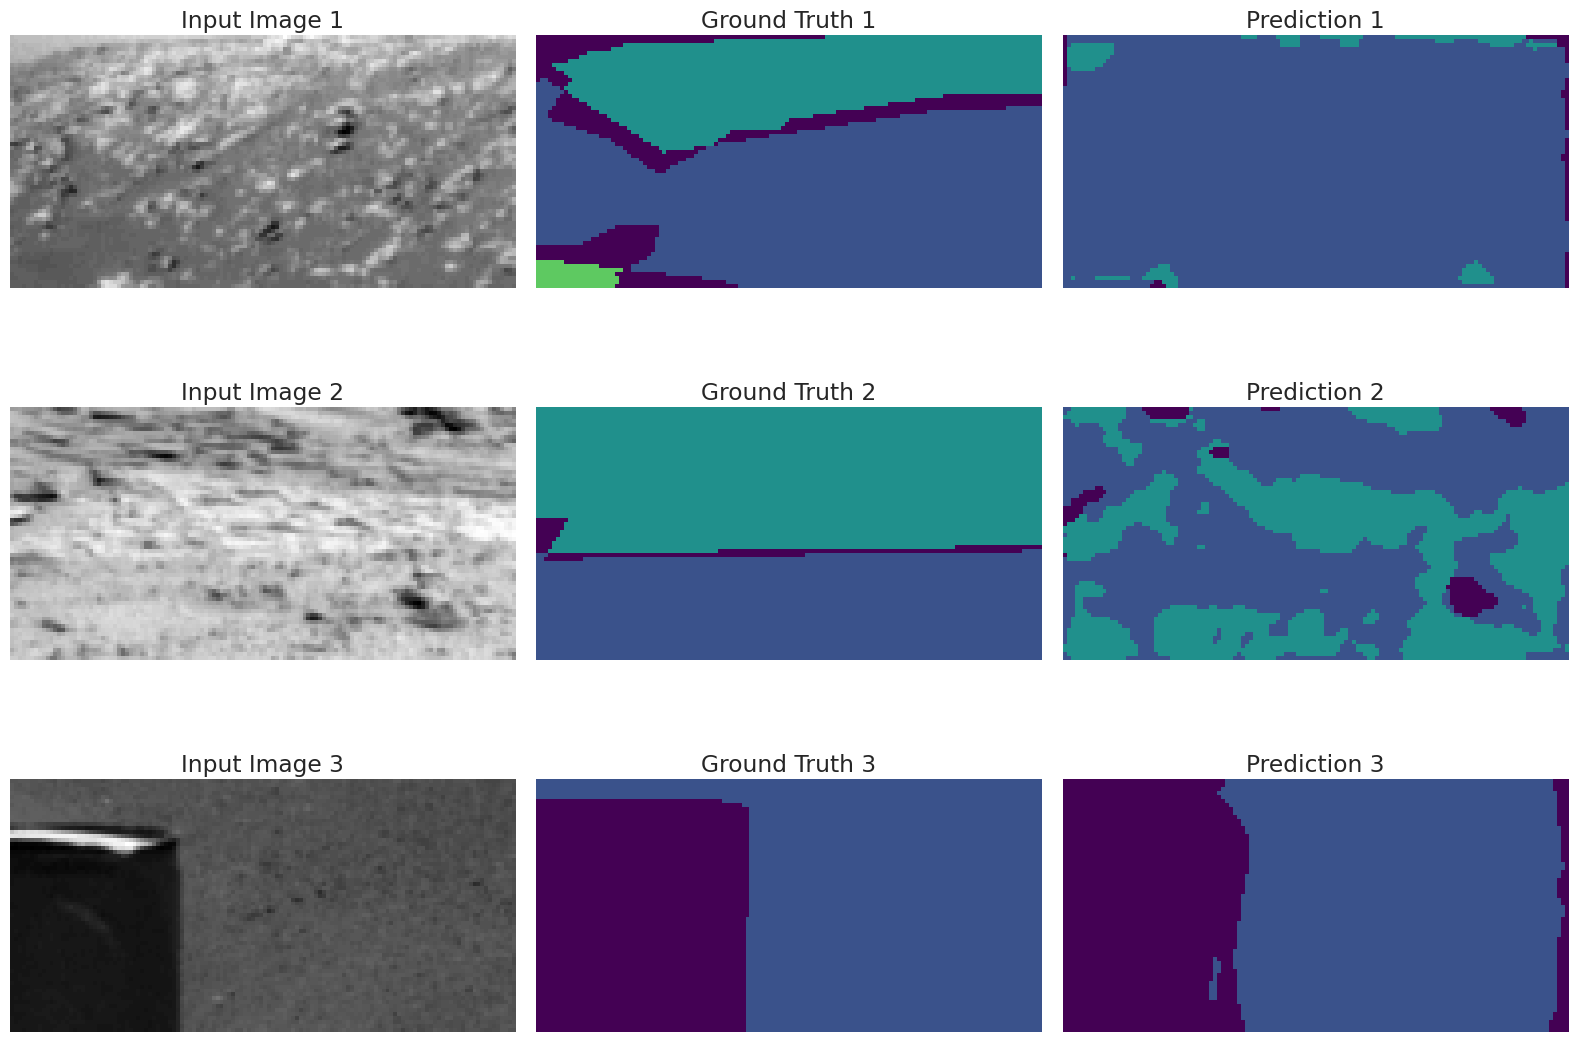

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.5269 - loss: 1.1176 - mean_iou: 0.2216 - val_accuracy: 0.7118 - val_loss: 0.8809 - val_mean_iou: 0.4058 - learning_rate: 0.0010
Epoch 2/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.7121 - loss: 0.8786 - mean_iou: 0.3682 - val_accuracy: 0.6573 - val_loss: 0.9539 - val_mean_iou: 0.3771 - learning_rate: 0.0010
Epoch 3/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.7397 - loss: 0.8339 - mean_iou: 0.4111 - val_accuracy: 0.6461 - val_loss: 0.9575 - val_mean_iou: 0.3586 - learning_rate: 0.0010
Epoch 4/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.7602 - loss: 0.7986 - mean_iou: 0.4406 - val_accuracy: 0.7243 - val_loss: 0.8606 - val_mean_iou: 0.4486 - learning_rate: 0.0010
Epoch 5/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.7723 - loss: 0.7753 - mean_iou: 0.4612 - val_accuracy: 0.3801 - val_loss: 1.4775 - val_mean_iou: 0.1096 - learning_rate: 0.0010
Epoch 6/160
1002

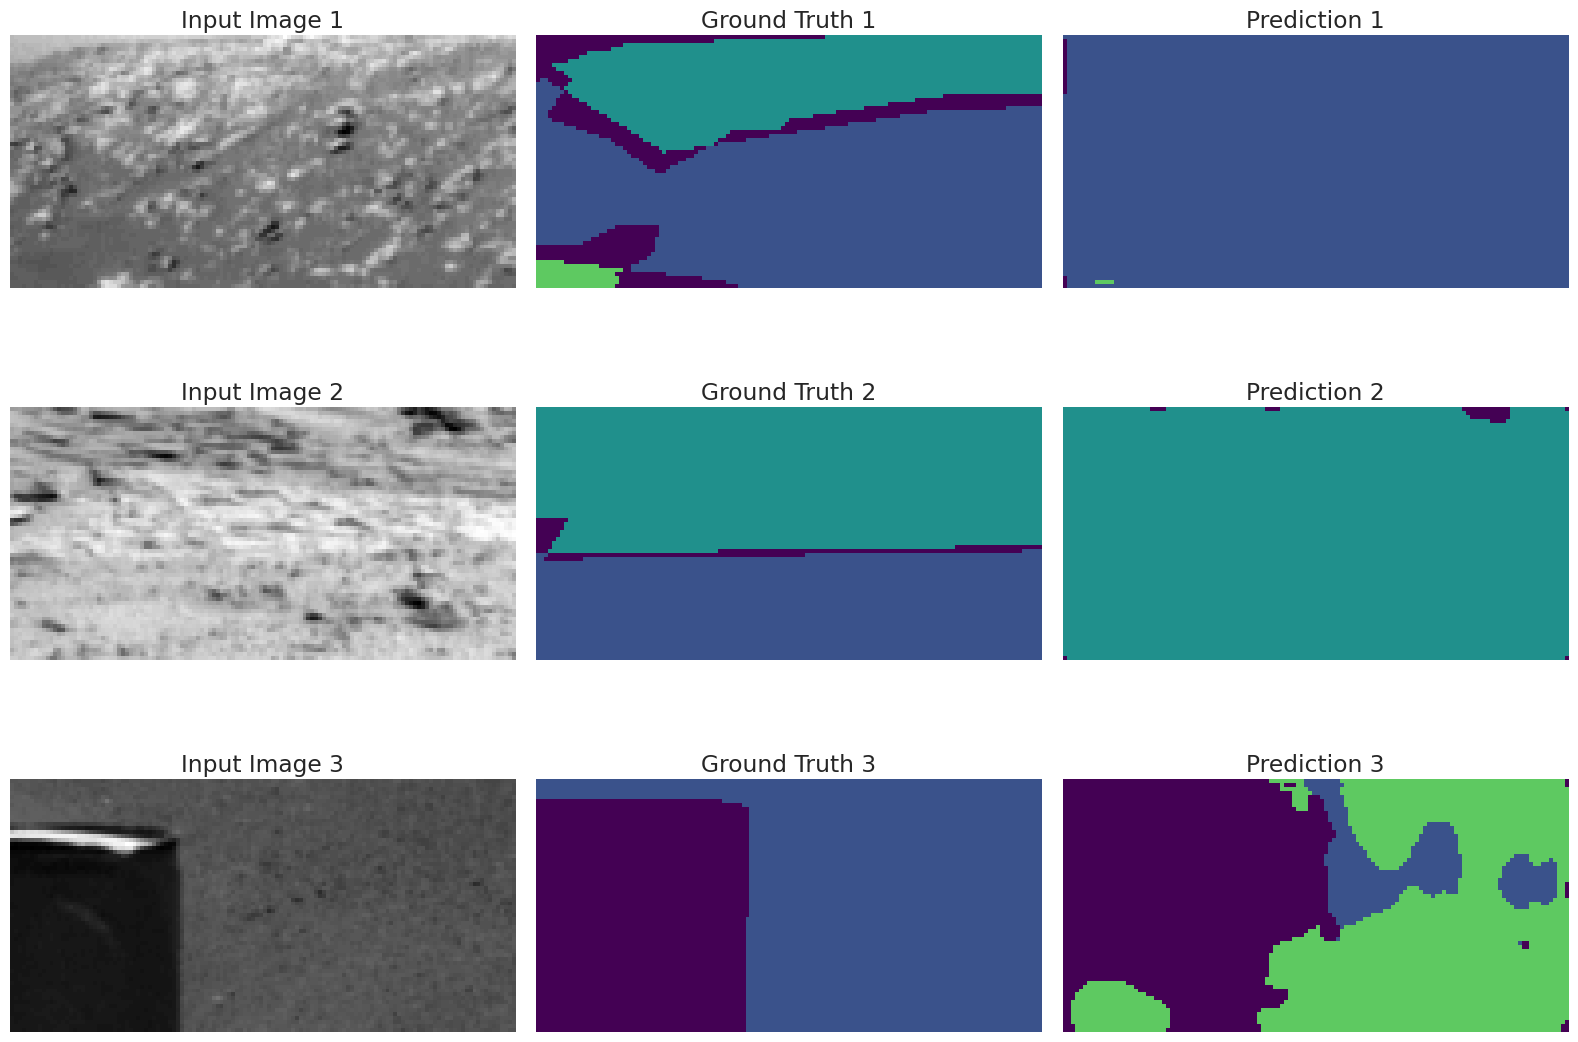

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.7854 - loss: 0.7535 - mean_iou: 0.4796 - val_accuracy: 0.7521 - val_loss: 0.8493 - val_mean_iou: 0.4796 - learning_rate: 0.0010
Epoch 7/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7957 - loss: 0.7361 - mean_iou: 0.4963 - val_accuracy: 0.7432 - val_loss: 0.8290 - val_mean_iou: 0.4904 - learning_rate: 0.0010
Epoch 8/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.8020 - loss: 0.7240 - mean_iou: 0.5086 - val_accuracy: 0.7847 - val_loss: 0.7644 - val_mean_iou: 0.5375 - learning_rate: 0.0010
Epoch 9/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.8125 - loss: 0.7075 - mean_iou: 0.5224 - val_accuracy: 0.7588 - val_loss: 0.7938 - val_mean_iou: 0.5161 - learning_rate: 0.0010
Epoch 10/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8182 - loss: 0.6957 - mean_iou: 0.5420 - val_accuracy: 0.7877 - val_loss: 0.7615 - val_mean_iou: 0.5465 - learning_rate: 0.0010
Epoch 11/160
100

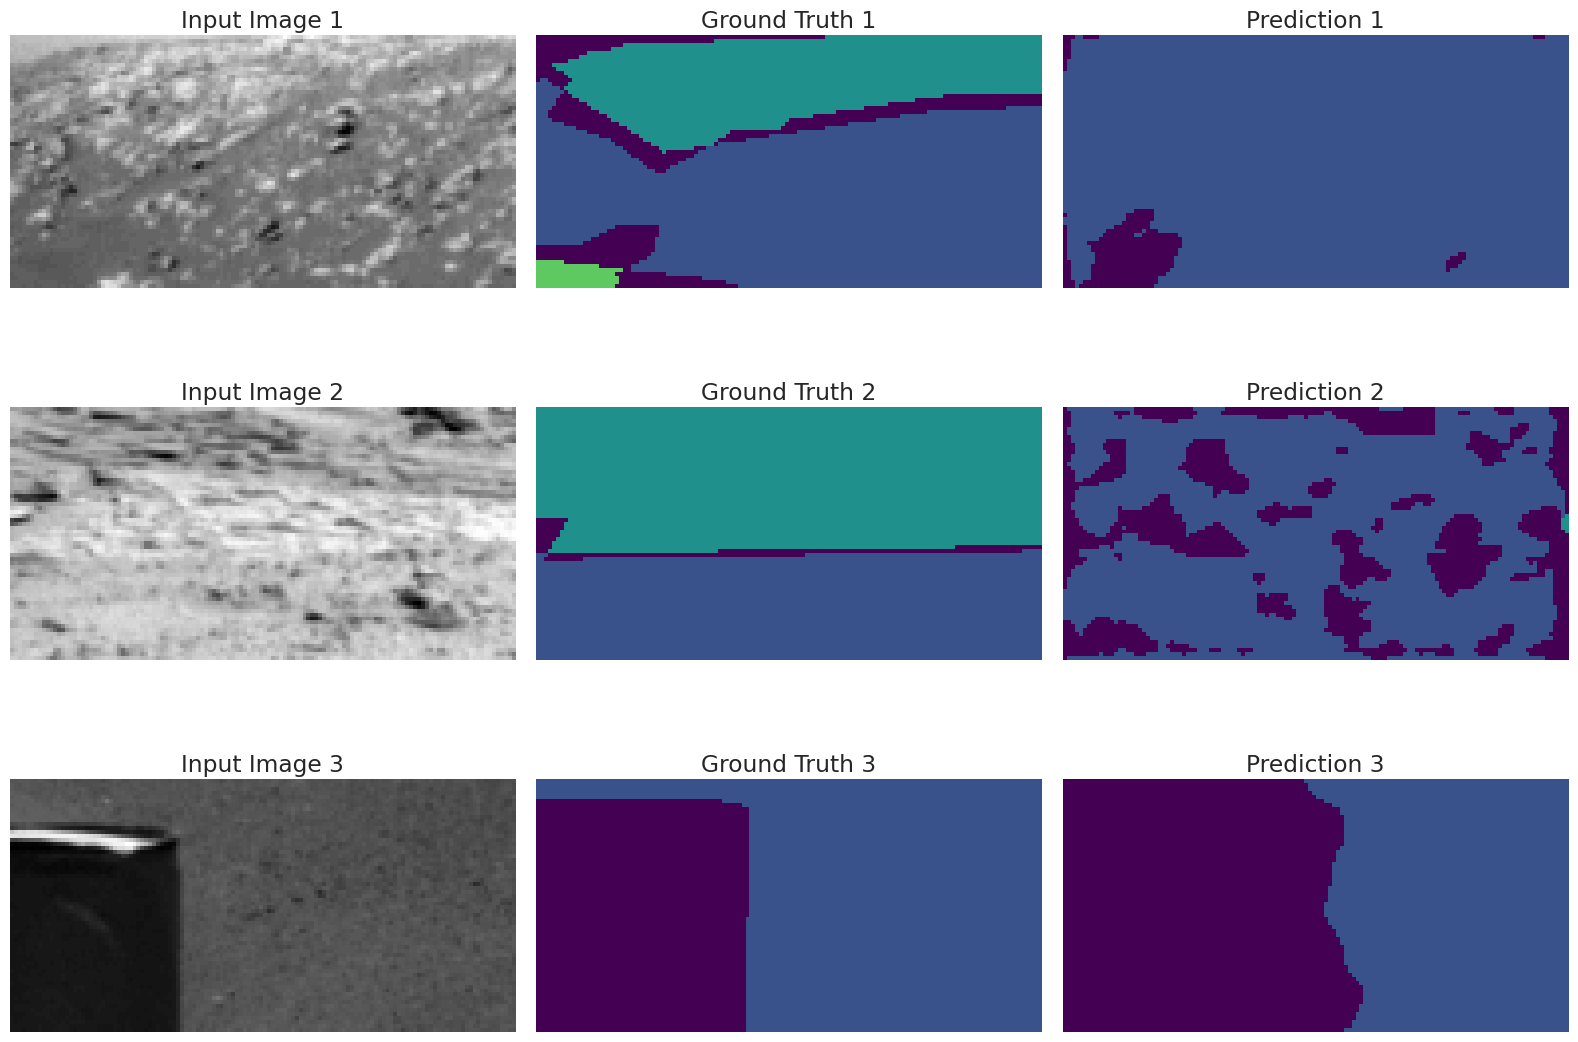

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.8255 - loss: 0.6835 - mean_iou: 0.5574 - val_accuracy: 0.7571 - val_loss: 0.8289 - val_mean_iou: 0.4536 - learning_rate: 0.0010
Epoch 12/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8322 - loss: 0.6732 - mean_iou: 0.5645 - val_accuracy: 0.7781 - val_loss: 0.7721 - val_mean_iou: 0.5307 - learning_rate: 0.0010
Epoch 13/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8389 - loss: 0.6614 - mean_iou: 0.5781 - val_accuracy: 0.7619 - val_loss: 0.8054 - val_mean_iou: 0.4670 - learning_rate: 0.0010
Epoch 14/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.8456 - loss: 0.6498 - mean_iou: 0.5873 - val_accuracy: 0.7710 - val_loss: 0.7988 - val_mean_iou: 0.4888 - learning_rate: 0.0010
Epoch 15/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8474 - loss: 0.6473 - mean_iou: 0.5877 - val_accuracy: 0.6807 - val_loss: 0.9922 - val_mean_iou: 0.3743 - learning_rate: 0.0010
Epoch 16/160


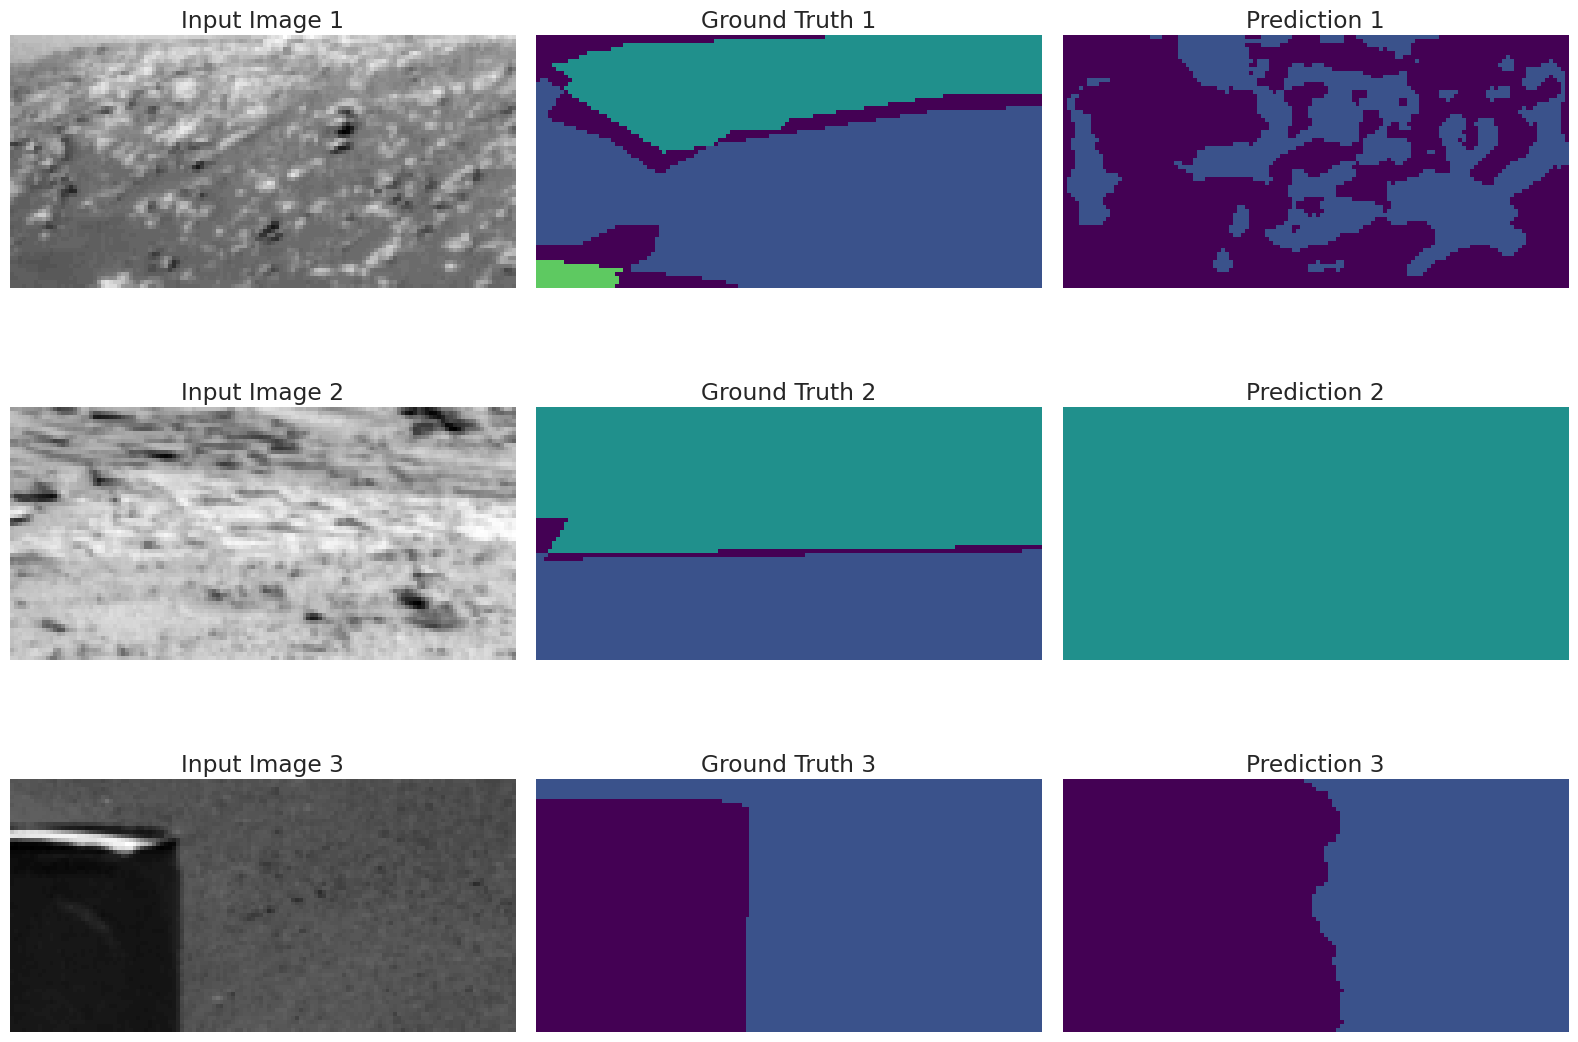

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.8567 - loss: 0.6312 - mean_iou: 0.6041 - val_accuracy: 0.7572 - val_loss: 0.8295 - val_mean_iou: 0.4704 - learning_rate: 0.0010
Epoch 17/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.8640 - loss: 0.6213 - mean_iou: 0.6162 - val_accuracy: 0.7751 - val_loss: 0.8247 - val_mean_iou: 0.4789 - learning_rate: 0.0010
Epoch 18/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.8683 - loss: 0.6125 - mean_iou: 0.6252 - val_accuracy: 0.7147 - val_loss: 0.9826 - val_mean_iou: 0.4078 - learning_rate: 0.0010
Epoch 19/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.8809 - loss: 0.5911 - mean_iou: 0.6514 - val_accuracy: 0.7959 - val_loss: 0.7904 - val_mean_iou: 0.5005 - learning_rate: 1.0000e-04
Epoch 20/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.8892 - loss: 0.5771 - mean_iou: 0.6645 - val_accuracy: 0.7971 - val_loss: 0.7964 - val_mean_iou: 0.4988 - learning_rate: 1.0000e-04
Epoch

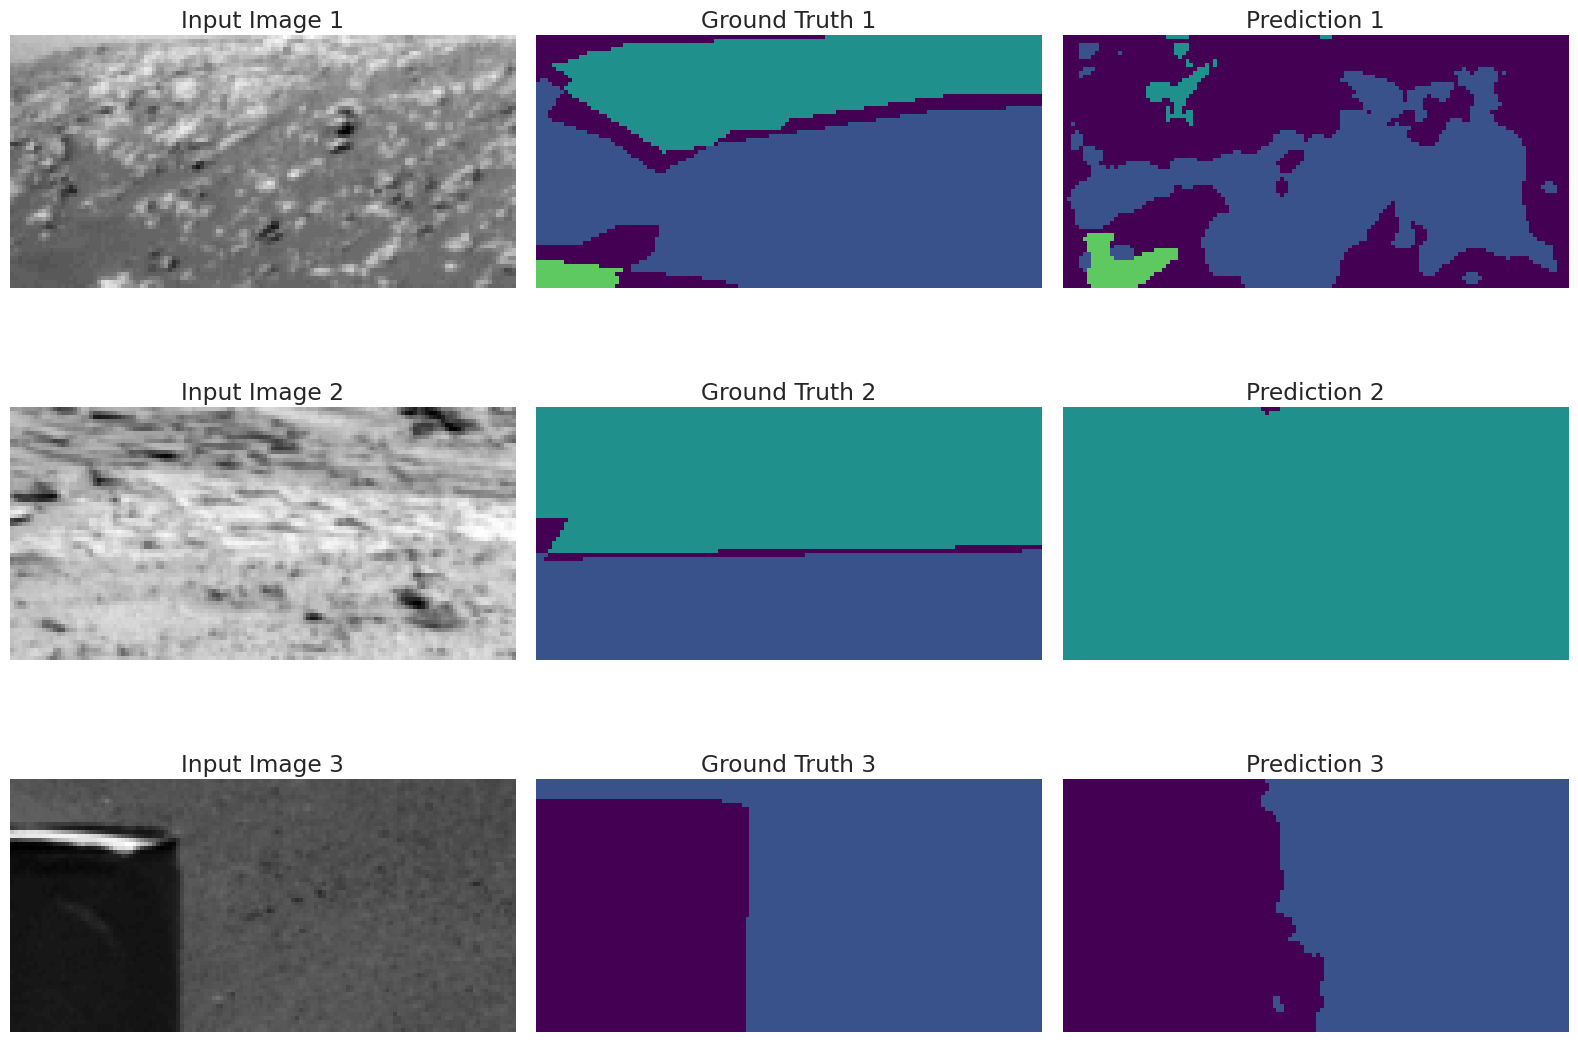

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8925 - loss: 0.5725 - mean_iou: 0.6689 - val_accuracy: 0.7959 - val_loss: 0.8051 - val_mean_iou: 0.4973 - learning_rate: 1.0000e-04
Epoch 22/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8952 - loss: 0.5685 - mean_iou: 0.6725 - val_accuracy: 0.7951 - val_loss: 0.8097 - val_mean_iou: 0.4966 - learning_rate: 1.0000e-04
Epoch 23/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8975 - loss: 0.5650 - mean_iou: 0.6755 - val_accuracy: 0.7933 - val_loss: 0.8156 - val_mean_iou: 0.4948 - learning_rate: 1.0000e-04
Epoch 24/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.8995 - loss: 0.5618 - mean_iou: 0.6786 - val_accuracy: 0.7920 - val_loss: 0.8206 - val_mean_iou: 0.4945 - learning_rate: 1.0000e-04
Epoch 25/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9013 - loss: 0.5587 - mean_iou: 0.6814 - val_accuracy: 0.7909 - val_loss: 0.8220 - val_mean_iou: 0.4938 - learning_rate: 1.00

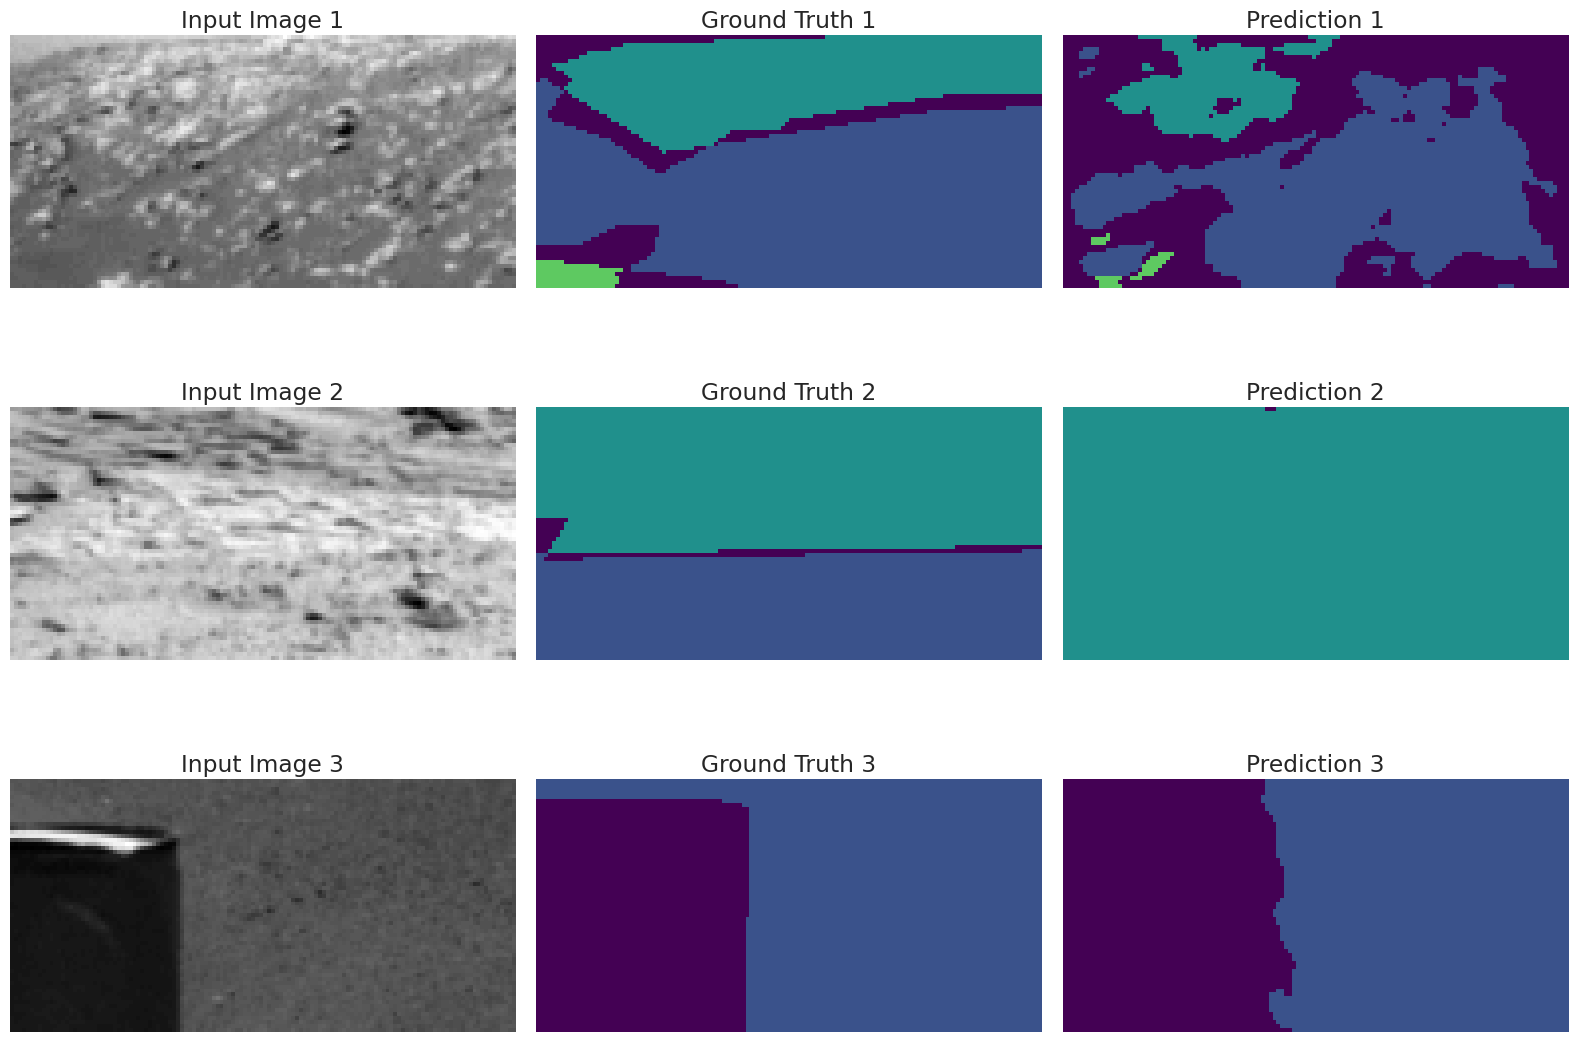

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9031 - loss: 0.5555 - mean_iou: 0.6840 - val_accuracy: 0.7896 - val_loss: 0.8270 - val_mean_iou: 0.4921 - learning_rate: 1.0000e-04
Epoch 27/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9047 - loss: 0.5526 - mean_iou: 0.6865 - val_accuracy: 0.7888 - val_loss: 0.8314 - val_mean_iou: 0.4912 - learning_rate: 1.0000e-04
Epoch 28/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9064 - loss: 0.5494 - mean_iou: 0.6890 - val_accuracy: 0.7884 - val_loss: 0.8335 - val_mean_iou: 0.4907 - learning_rate: 1.0000e-04
Epoch 29/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9080 - loss: 0.5466 - mean_iou: 0.6914 - val_accuracy: 0.7865 - val_loss: 0.8412 - val_mean_iou: 0.4890 - learning_rate: 1.0000e-04
Epoch 30/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9095 - loss: 0.5437 - mean_iou: 0.6938 - val_accuracy: 0.7856 - val_loss: 0.8483 - val_mean_iou: 0.4886 - learning_rate: 1.00

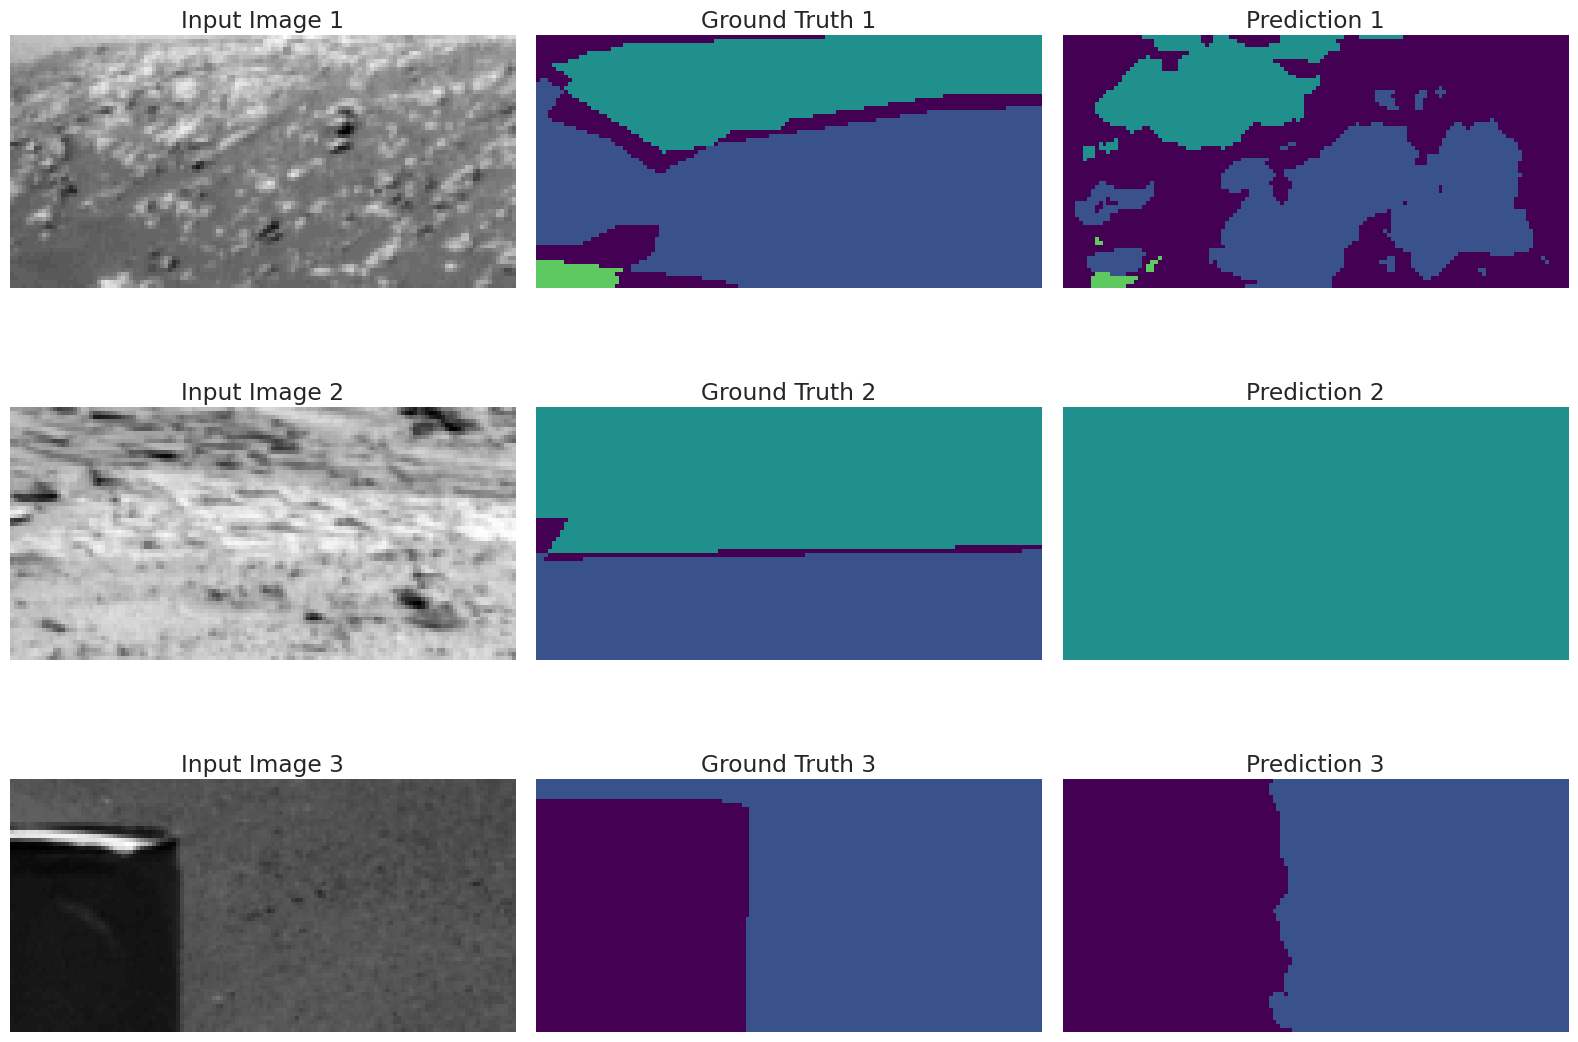

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.9108 - loss: 0.5412 - mean_iou: 0.6962 - val_accuracy: 0.7864 - val_loss: 0.8475 - val_mean_iou: 0.4873 - learning_rate: 1.0000e-04
Epoch 32/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.9122 - loss: 0.5384 - mean_iou: 0.6986 - val_accuracy: 0.7830 - val_loss: 0.8544 - val_mean_iou: 0.4845 - learning_rate: 1.0000e-04
Epoch 33/160
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9135 - loss: 0.5359 - mean_iou: 0.7007 - val_accuracy: 0.7811 - val_loss: 0.8596 - val_mean_iou: 0.4835 - learning_rate: 1.0000e-04
Final validation Mean Intersection Over Union: 54.65%


In [49]:
# Train the model
history = unet_with_attention.fit(
    X_train,
    y_train,
    epochs=epochs,
    callbacks=[earlystop, viz_callback, plateau],
    verbose=1,
    validation_data=(X_val, y_val)
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f'Flagship_{final_val_meanIoU}_{timestep_str}.keras'
unet_with_attention.save(model_filename)
del unet_with_attention

## Training baseline model

In [81]:
# Define callbacks for early stopping and learning rate reduction

earlystop = tf.keras.callbacks.EarlyStopping(
      monitor="val_mean_iou",
      mode='max',
      patience=15,
      min_delta=0.01,  # Only consider changes >= 0.01 as improvements
      restore_best_weights=False
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor= "val_mean_iou",
      mode='max',
      factor=0.1,
      min_delta=0.01,
      patience=10,
      min_lr=1e-4
)

viz_callback = VizCallback(X_val[26:29], y_val[26:29])

Epoch 1/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4219 - loss: 1.3606 - mean_iou: 0.1994

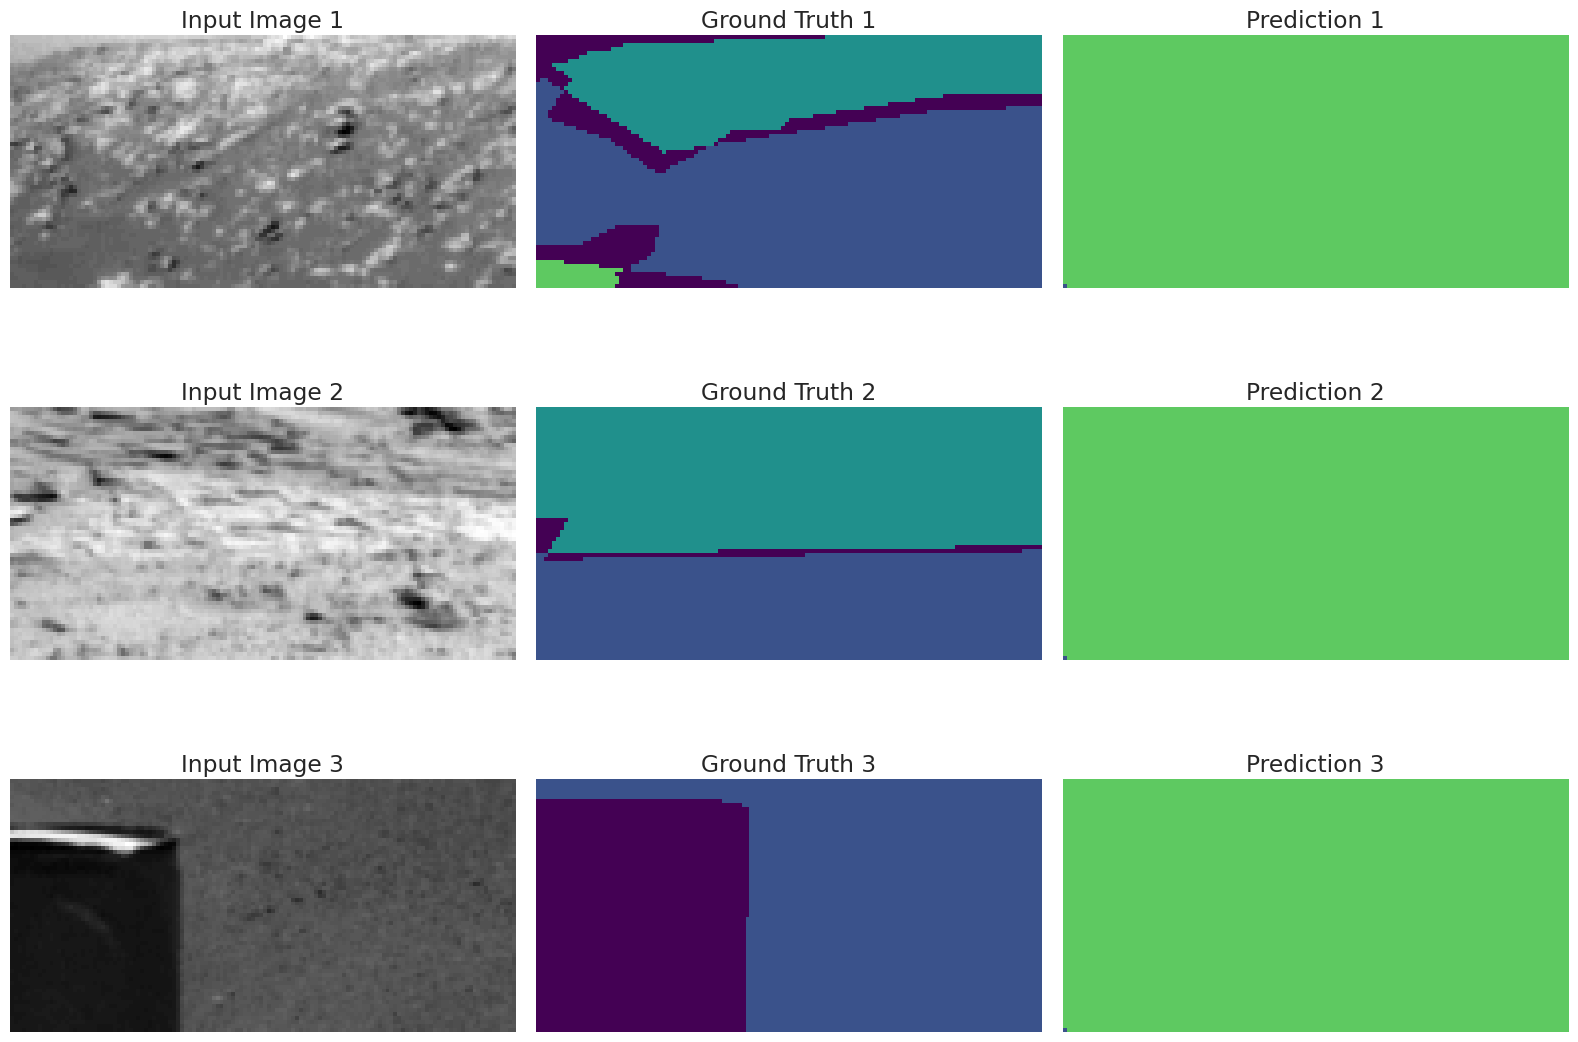

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.4227 - loss: 1.3588 - mean_iou: 0.1999 - val_accuracy: 0.1801 - val_loss: 2.4562 - val_mean_iou: 0.0608 - learning_rate: 0.0010
Epoch 2/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5576 - loss: 1.0804 - mean_iou: 0.2848 - val_accuracy: 0.1801 - val_loss: 4.8656 - val_mean_iou: 0.0607 - learning_rate: 0.0010
Epoch 3/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5968 - loss: 1.0068 - mean_iou: 0.3191 - val_accuracy: 0.1801 - val_loss: 4.7479 - val_mean_iou: 0.0486 - learning_rate: 0.0010
Epoch 4/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6390 - loss: 0.9255 - mean_iou: 0.3472 - val_accuracy: 0.1802 - val_loss: 5.4181 - val_mean_iou: 0.0486 - learning_rate: 0.0010
Epoch 5/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6647 - loss: 0.8762 - mean_iou: 0.3712 - val_accuracy: 0.1816 - val_loss: 4.5081 - val_mean_iou: 0.0495 - learning_rate: 0.0010
Epoch 6/160
61/63 ━━━━━━━━━━━━━━━━━━━━ 0

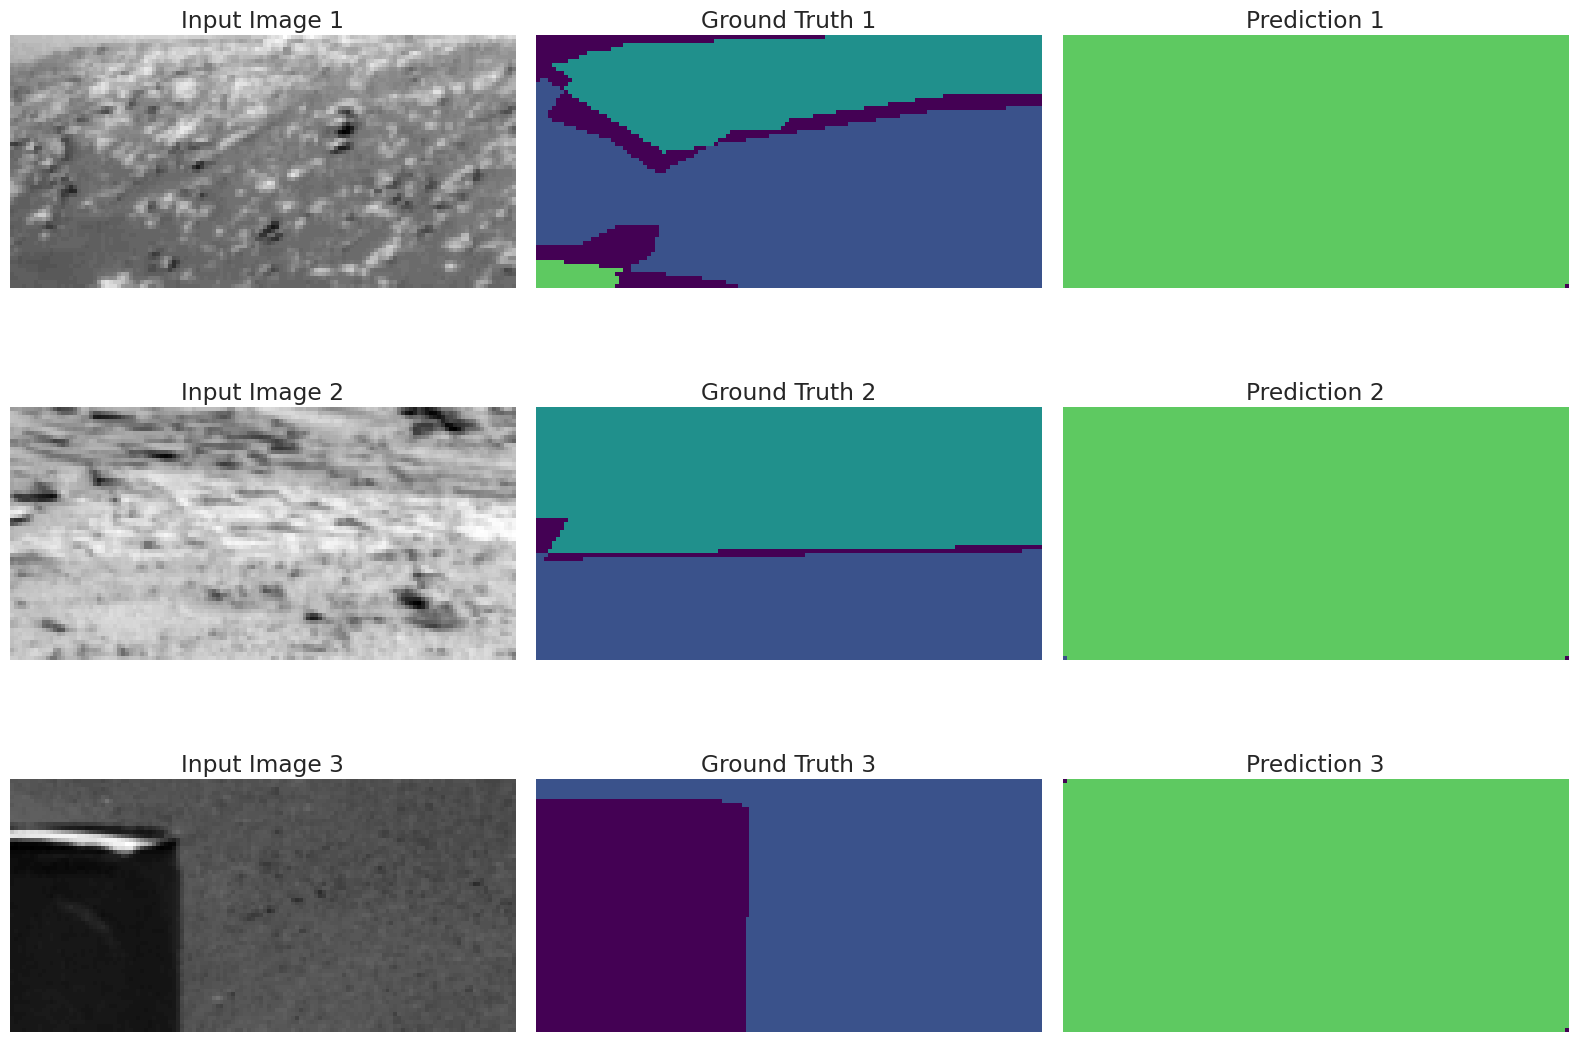

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6718 - loss: 0.8553 - mean_iou: 0.3788 - val_accuracy: 0.1957 - val_loss: 3.1248 - val_mean_iou: 0.0575 - learning_rate: 0.0010
Epoch 7/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6905 - loss: 0.8181 - mean_iou: 0.3939 - val_accuracy: 0.2445 - val_loss: 2.7001 - val_mean_iou: 0.0853 - learning_rate: 0.0010
Epoch 8/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6999 - loss: 0.7897 - mean_iou: 0.4027 - val_accuracy: 0.2812 - val_loss: 2.3516 - val_mean_iou: 0.0919 - learning_rate: 0.0010
Epoch 9/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7019 - loss: 0.7849 - mean_iou: 0.4044 - val_accuracy: 0.4782 - val_loss: 1.4930 - val_mean_iou: 0.2102 - learning_rate: 0.0010
Epoch 10/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7122 - loss: 0.7586 - mean_iou: 0.4137 - val_accuracy: 0.6080 - val_loss: 1.0548 - val_mean_iou: 0.3186 - learning_rate: 0.0010
Epoch 11/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 0

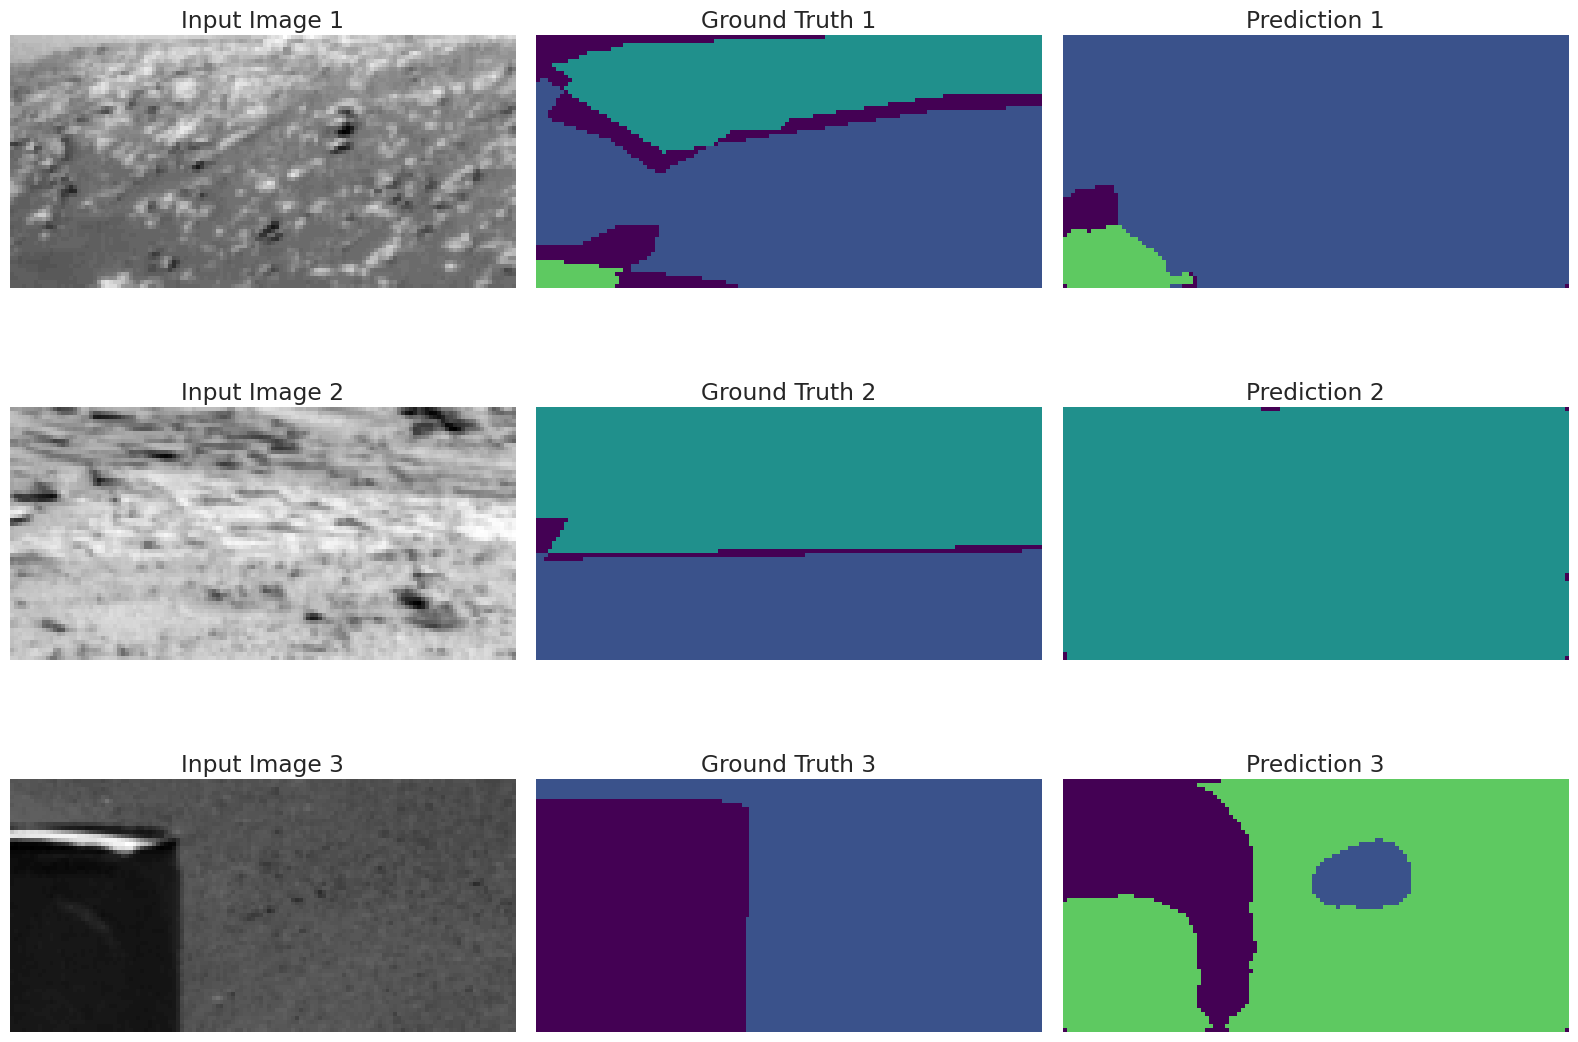

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7186 - loss: 0.7422 - mean_iou: 0.4189 - val_accuracy: 0.6032 - val_loss: 1.0532 - val_mean_iou: 0.3119 - learning_rate: 0.0010
Epoch 12/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7191 - loss: 0.7437 - mean_iou: 0.4195 - val_accuracy: 0.6500 - val_loss: 0.9178 - val_mean_iou: 0.3329 - learning_rate: 0.0010
Epoch 13/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7317 - loss: 0.7137 - mean_iou: 0.4302 - val_accuracy: 0.6537 - val_loss: 0.9481 - val_mean_iou: 0.3452 - learning_rate: 0.0010
Epoch 14/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7383 - loss: 0.6891 - mean_iou: 0.4365 - val_accuracy: 0.6054 - val_loss: 1.0721 - val_mean_iou: 0.2945 - learning_rate: 0.0010
Epoch 15/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7429 - loss: 0.6733 - mean_iou: 0.4416 - val_accuracy: 0.5126 - val_loss: 1.6050 - val_mean_iou: 0.2047 - learning_rate: 0.0010
Epoch 16/160
61/63 ━━━━━━━━━━━━━━━━━━━

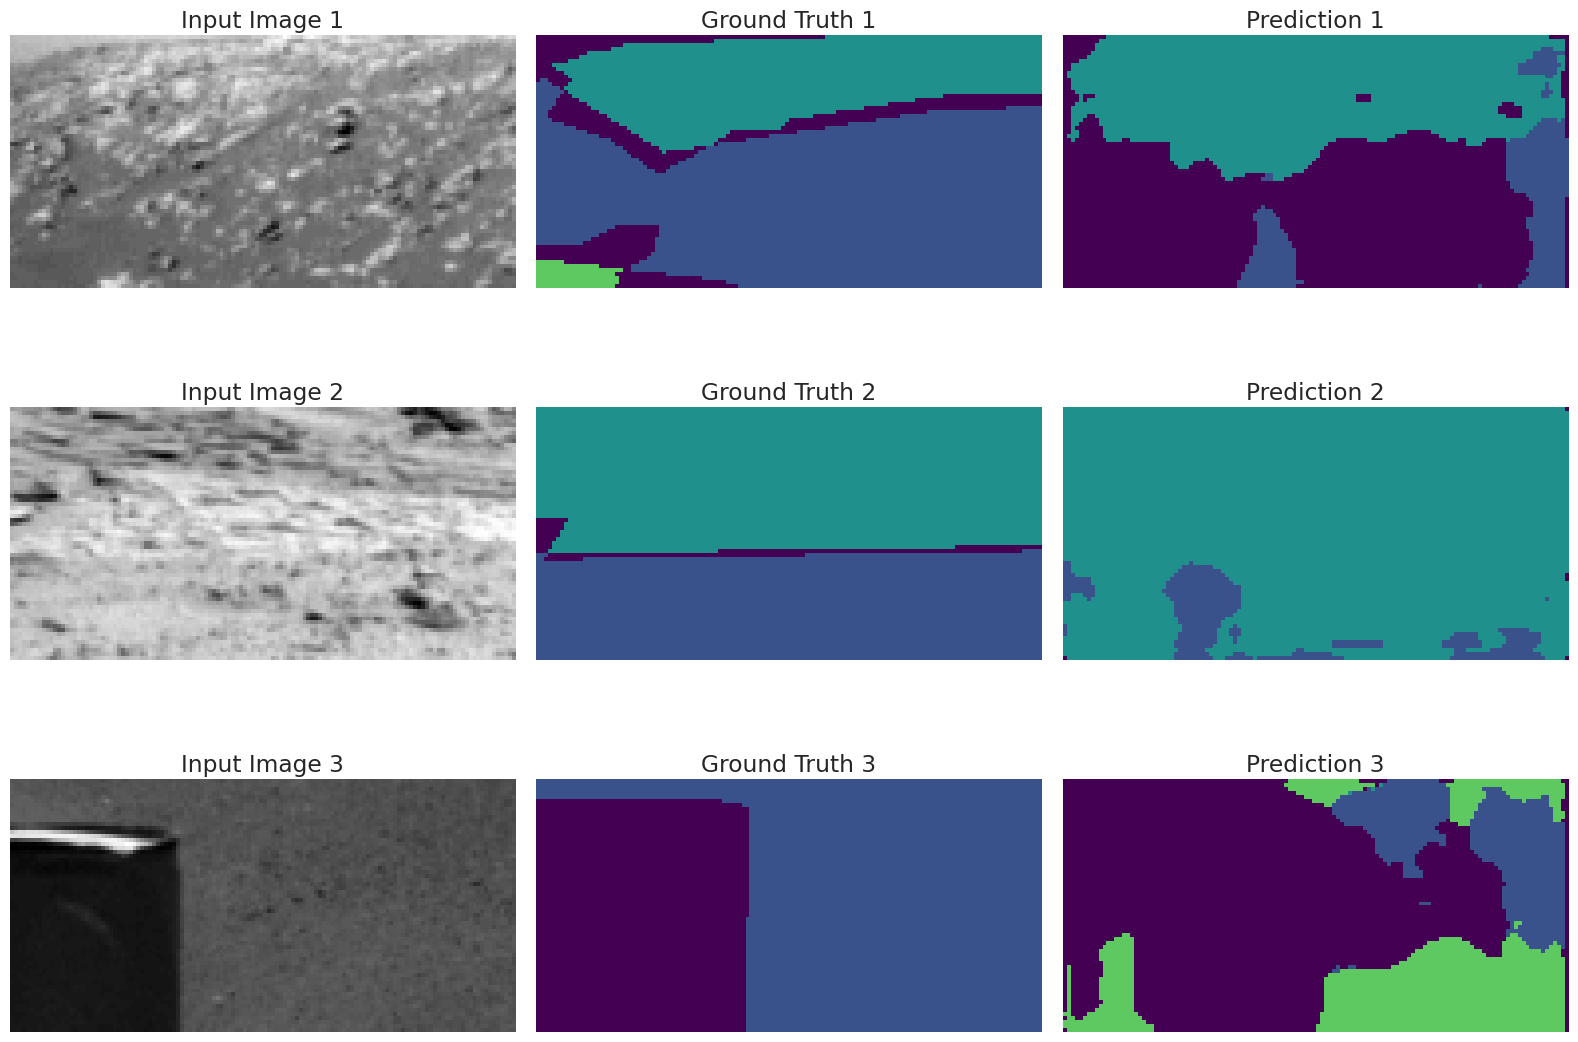

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7445 - loss: 0.6699 - mean_iou: 0.4429 - val_accuracy: 0.6821 - val_loss: 0.8460 - val_mean_iou: 0.3665 - learning_rate: 0.0010
Epoch 17/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7509 - loss: 0.6600 - mean_iou: 0.4499 - val_accuracy: 0.7255 - val_loss: 0.7290 - val_mean_iou: 0.4605 - learning_rate: 0.0010
Epoch 18/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7483 - loss: 0.6633 - mean_iou: 0.4448 - val_accuracy: 0.5820 - val_loss: 1.1342 - val_mean_iou: 0.2799 - learning_rate: 0.0010
Epoch 19/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7625 - loss: 0.6281 - mean_iou: 0.4578 - val_accuracy: 0.4922 - val_loss: 1.5742 - val_mean_iou: 0.2527 - learning_rate: 0.0010
Epoch 20/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7652 - loss: 0.6233 - mean_iou: 0.4607 - val_accuracy: 0.5195 - val_loss: 1.3886 - val_mean_iou: 0.2741 - learning_rate: 0.0010
Epoch 21/160
63/63 ━━━━━━━━━━━━━━━━━━━

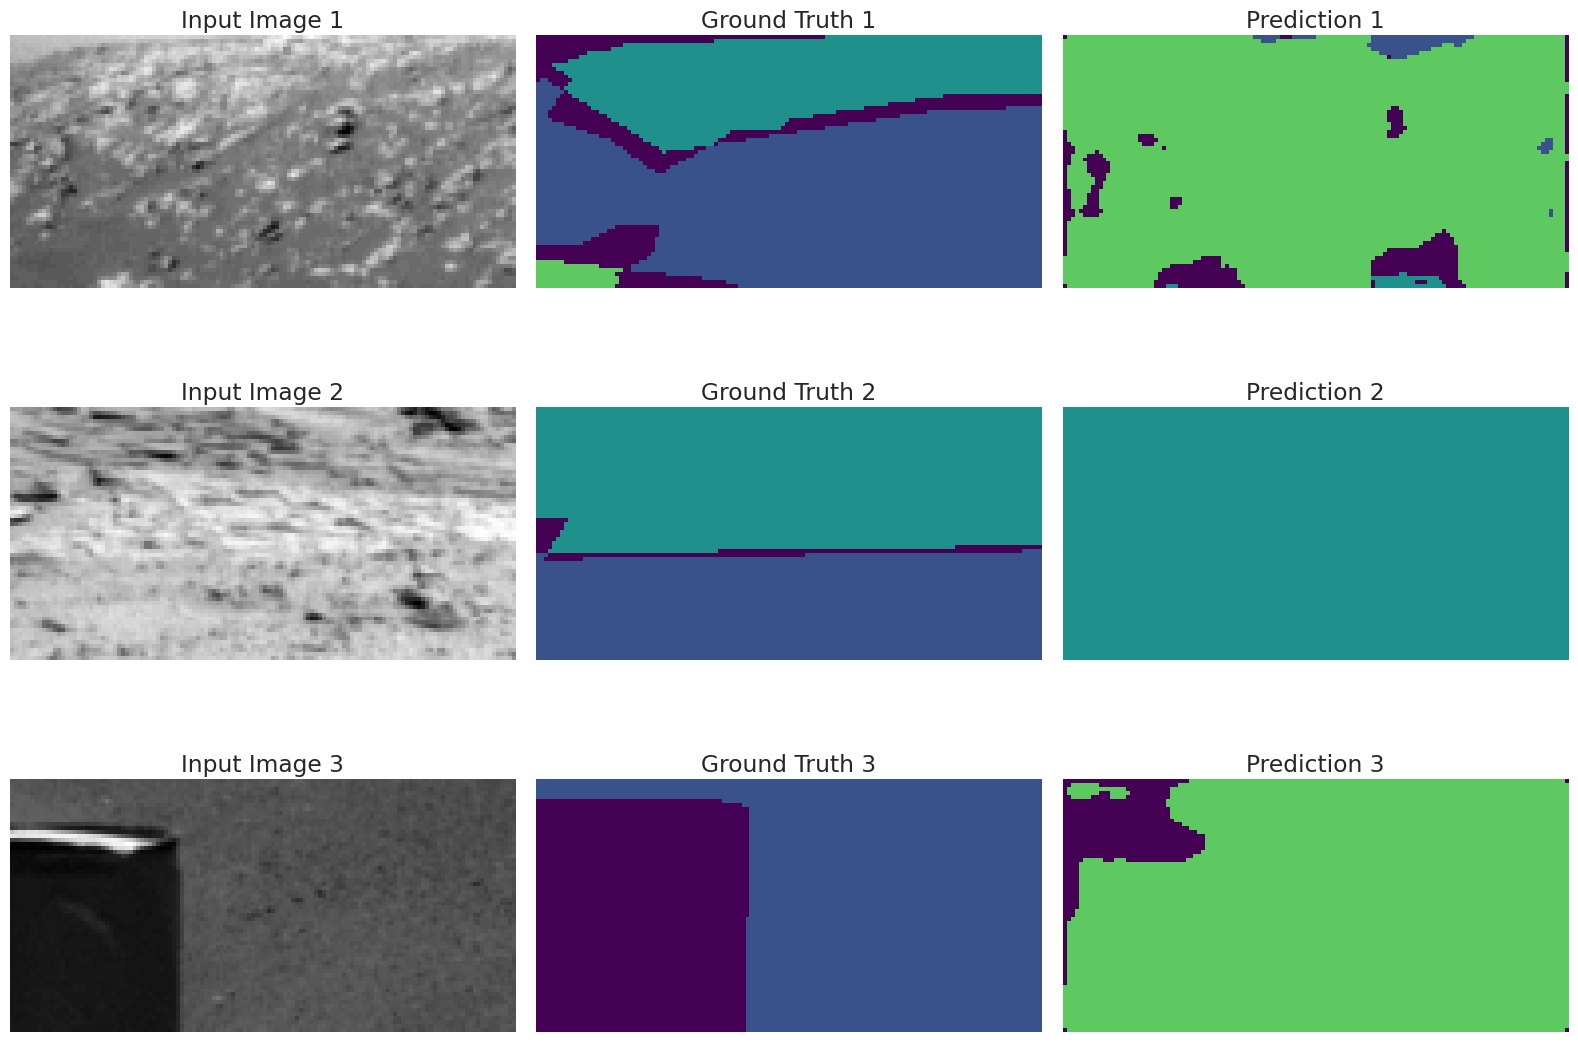

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7709 - loss: 0.6073 - mean_iou: 0.4660 - val_accuracy: 0.5587 - val_loss: 1.2582 - val_mean_iou: 0.2992 - learning_rate: 0.0010
Epoch 22/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7728 - loss: 0.6062 - mean_iou: 0.4662 - val_accuracy: 0.6770 - val_loss: 0.9141 - val_mean_iou: 0.3778 - learning_rate: 0.0010
Epoch 23/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7799 - loss: 0.5866 - mean_iou: 0.4734 - val_accuracy: 0.7056 - val_loss: 0.7899 - val_mean_iou: 0.4170 - learning_rate: 0.0010
Epoch 24/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7771 - loss: 0.5982 - mean_iou: 0.4702 - val_accuracy: 0.5281 - val_loss: 1.4081 - val_mean_iou: 0.2205 - learning_rate: 0.0010
Epoch 25/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7748 - loss: 0.5955 - mean_iou: 0.4680 - val_accuracy: 0.4845 - val_loss: 1.5142 - val_mean_iou: 0.2073 - learning_rate: 0.0010
Epoch 26/160
61/63 ━━━━━━━━━━━━━━━━━━━

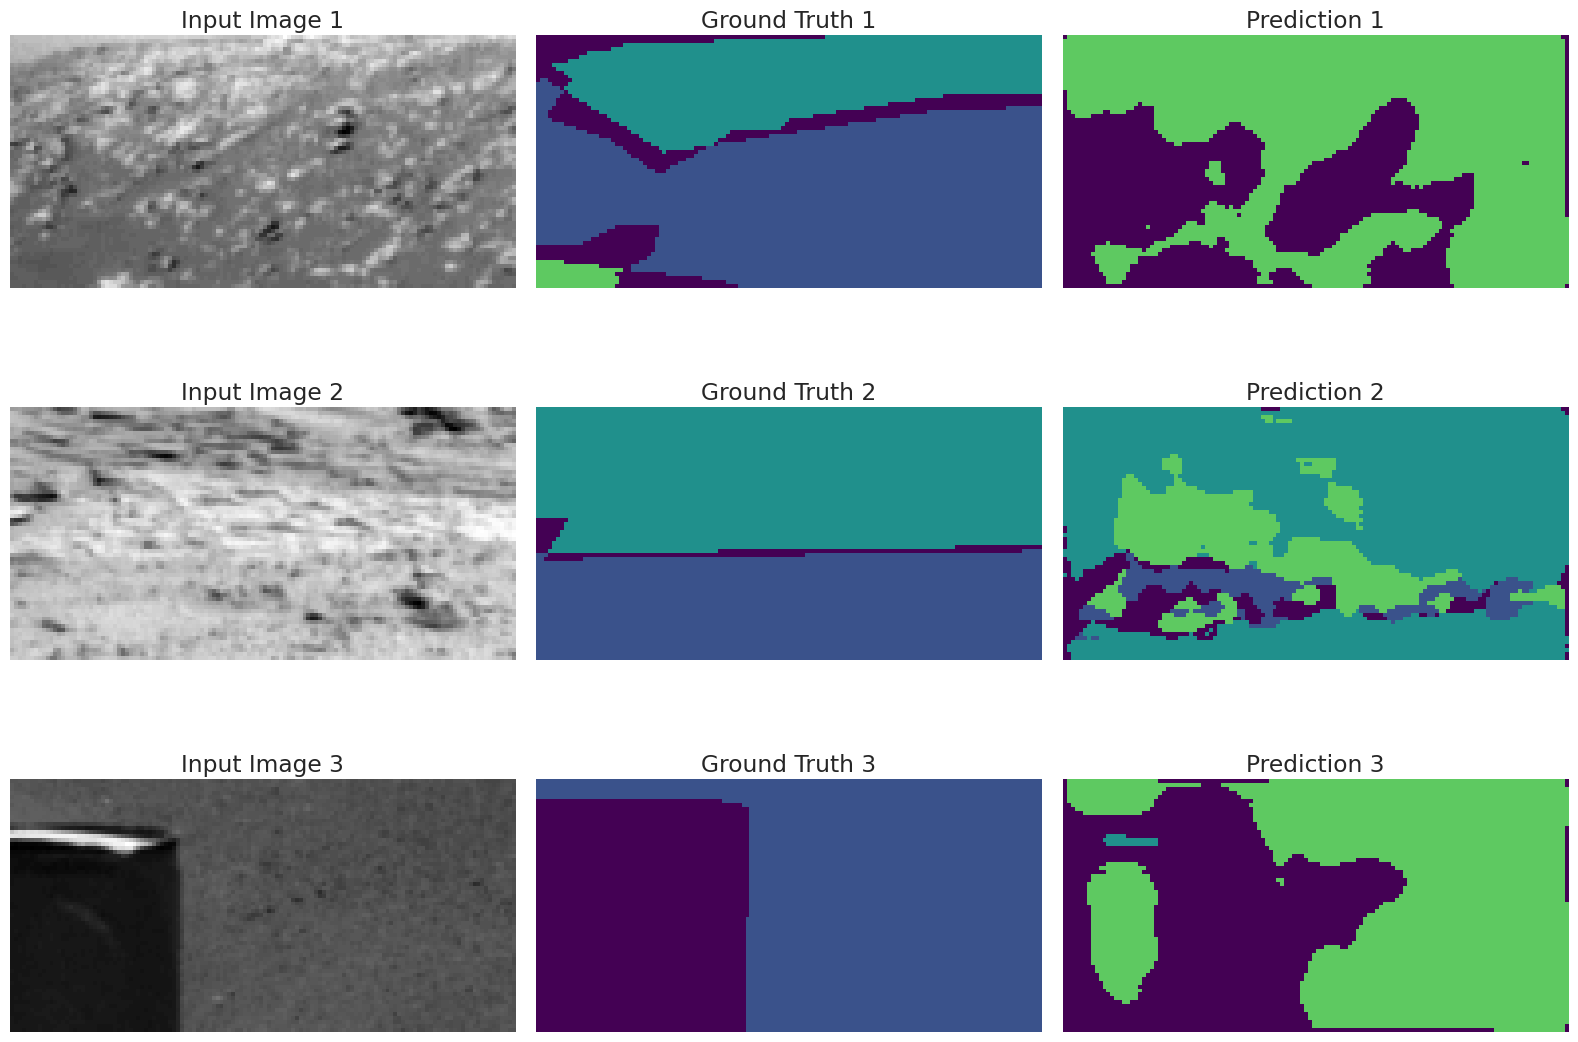

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7845 - loss: 0.5725 - mean_iou: 0.4760 - val_accuracy: 0.5460 - val_loss: 1.3773 - val_mean_iou: 0.2547 - learning_rate: 0.0010
Epoch 27/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7852 - loss: 0.5704 - mean_iou: 0.4793 - val_accuracy: 0.6986 - val_loss: 0.9617 - val_mean_iou: 0.4054 - learning_rate: 0.0010
Epoch 28/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7984 - loss: 0.5355 - mean_iou: 0.4939 - val_accuracy: 0.7545 - val_loss: 0.6364 - val_mean_iou: 0.4440 - learning_rate: 1.0000e-04
Epoch 29/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8166 - loss: 0.4902 - mean_iou: 0.5078 - val_accuracy: 0.7657 - val_loss: 0.5983 - val_mean_iou: 0.4697 - learning_rate: 1.0000e-04
Epoch 30/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8206 - loss: 0.4788 - mean_iou: 0.5110 - val_accuracy: 0.7647 - val_loss: 0.6025 - val_mean_iou: 0.4734 - learning_rate: 1.0000e-04
Epoch 31/160
60/63 ━━━━━━━

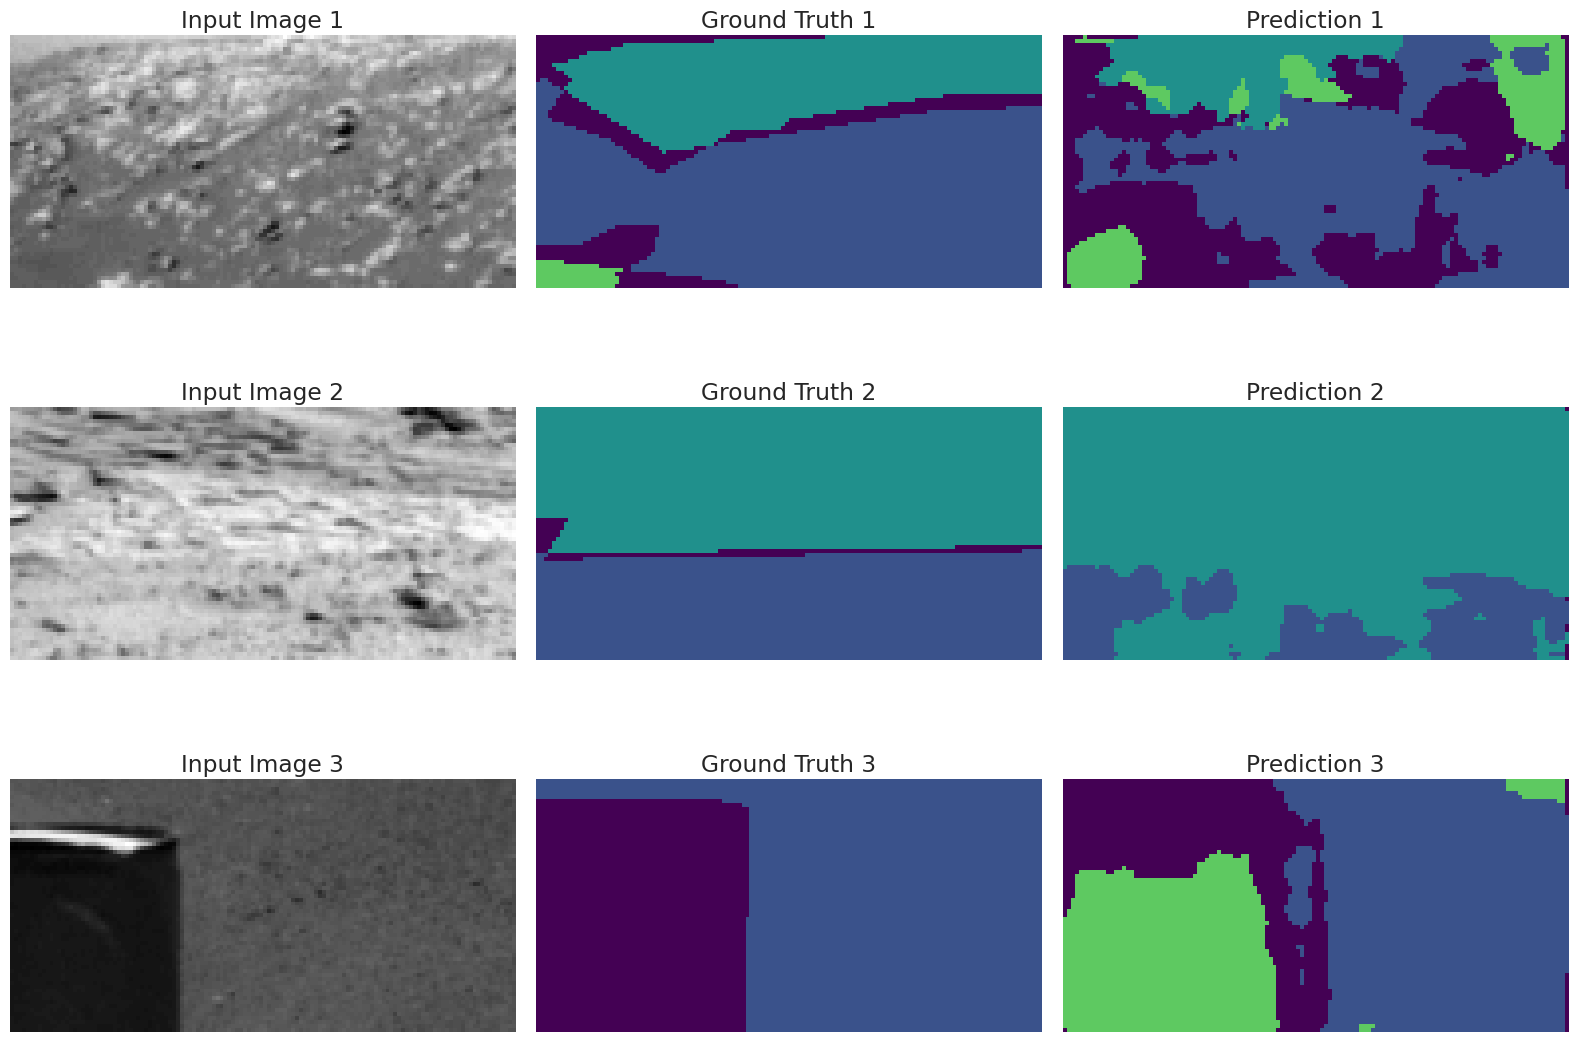

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8236 - loss: 0.4706 - mean_iou: 0.5135 - val_accuracy: 0.7643 - val_loss: 0.6066 - val_mean_iou: 0.4733 - learning_rate: 1.0000e-04
Epoch 32/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8262 - loss: 0.4636 - mean_iou: 0.5157 - val_accuracy: 0.7685 - val_loss: 0.6015 - val_mean_iou: 0.4748 - learning_rate: 1.0000e-04
Epoch 33/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8285 - loss: 0.4572 - mean_iou: 0.5176 - val_accuracy: 0.7676 - val_loss: 0.6051 - val_mean_iou: 0.4744 - learning_rate: 1.0000e-04
Epoch 34/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8309 - loss: 0.4510 - mean_iou: 0.5194 - val_accuracy: 0.7674 - val_loss: 0.6086 - val_mean_iou: 0.4743 - learning_rate: 1.0000e-04
Epoch 35/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8331 - loss: 0.4449 - mean_iou: 0.5212 - val_accuracy: 0.7653 - val_loss: 0.6170 - val_mean_iou: 0.4720 - learning_rate: 1.0000e-04
Epoch 36/160
62/63

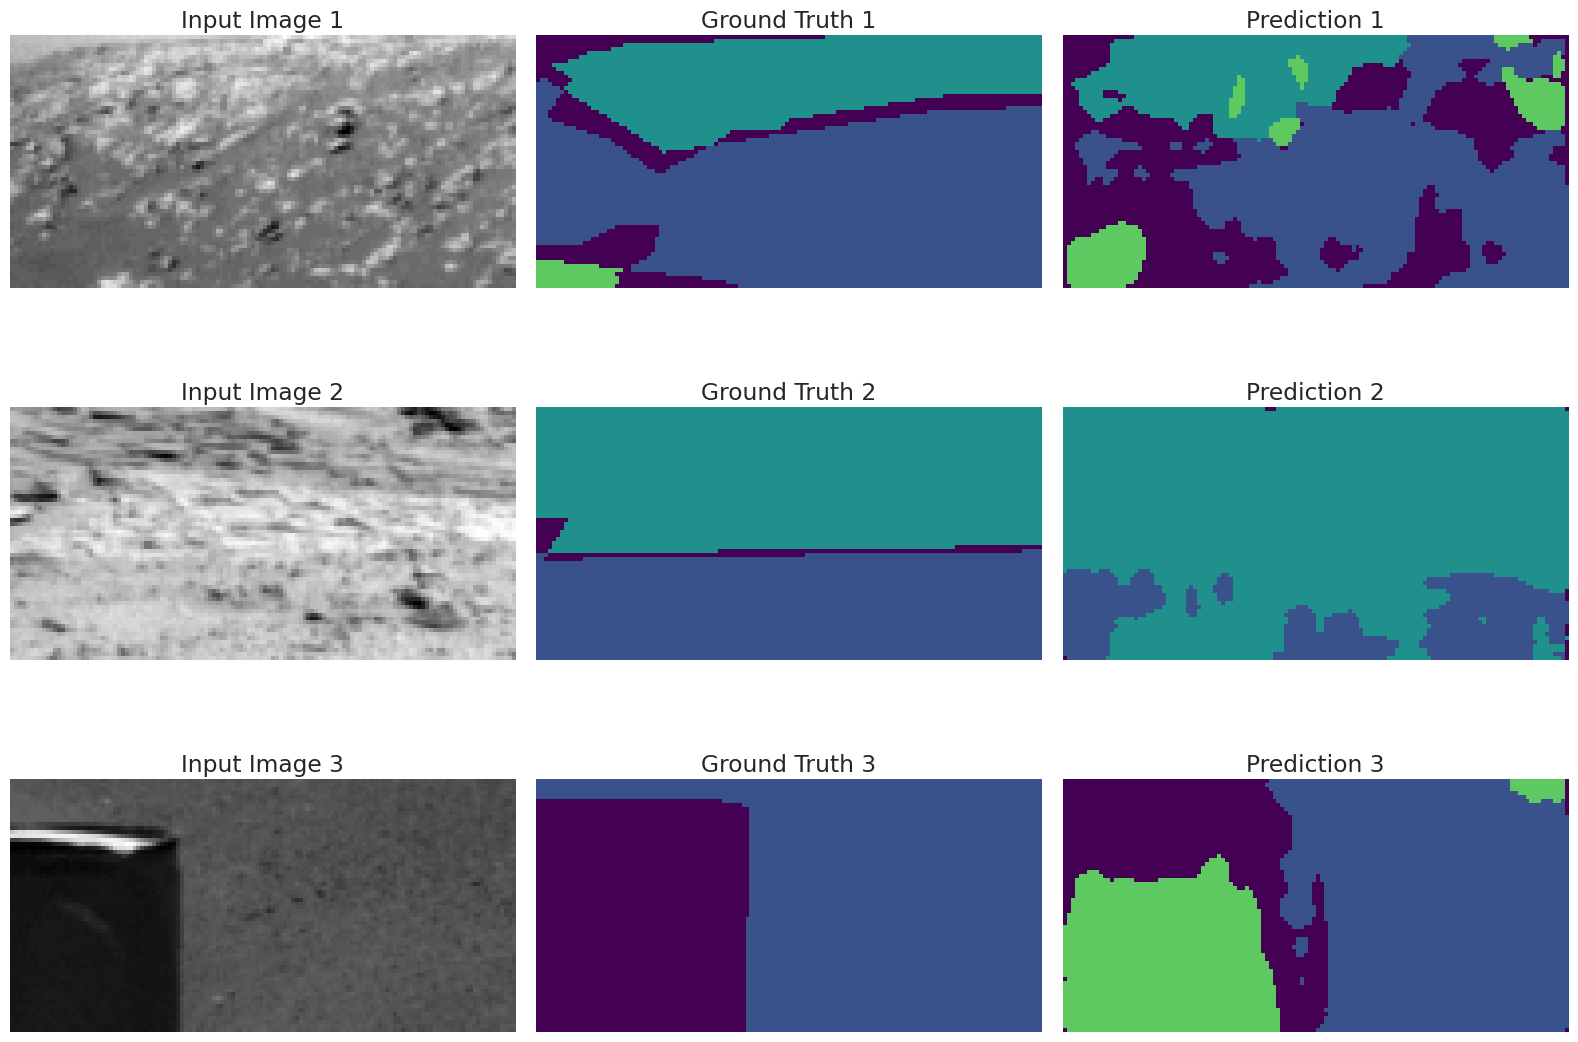

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8354 - loss: 0.4389 - mean_iou: 0.5228 - val_accuracy: 0.7668 - val_loss: 0.6155 - val_mean_iou: 0.4726 - learning_rate: 1.0000e-04
Epoch 37/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8376 - loss: 0.4329 - mean_iou: 0.5245 - val_accuracy: 0.7677 - val_loss: 0.6133 - val_mean_iou: 0.4736 - learning_rate: 1.0000e-04
Epoch 38/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8400 - loss: 0.4270 - mean_iou: 0.5262 - val_accuracy: 0.7662 - val_loss: 0.6200 - val_mean_iou: 0.4716 - learning_rate: 1.0000e-04
Epoch 39/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8422 - loss: 0.4211 - mean_iou: 0.5278 - val_accuracy: 0.7652 - val_loss: 0.6207 - val_mean_iou: 0.4720 - learning_rate: 1.0000e-04
Epoch 40/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8447 - loss: 0.4151 - mean_iou: 0.5295 - val_accuracy: 0.7659 - val_loss: 0.6247 - val_mean_iou: 0.4686 - learning_rate: 1.0000e-04
Epoch 41/160
61/63

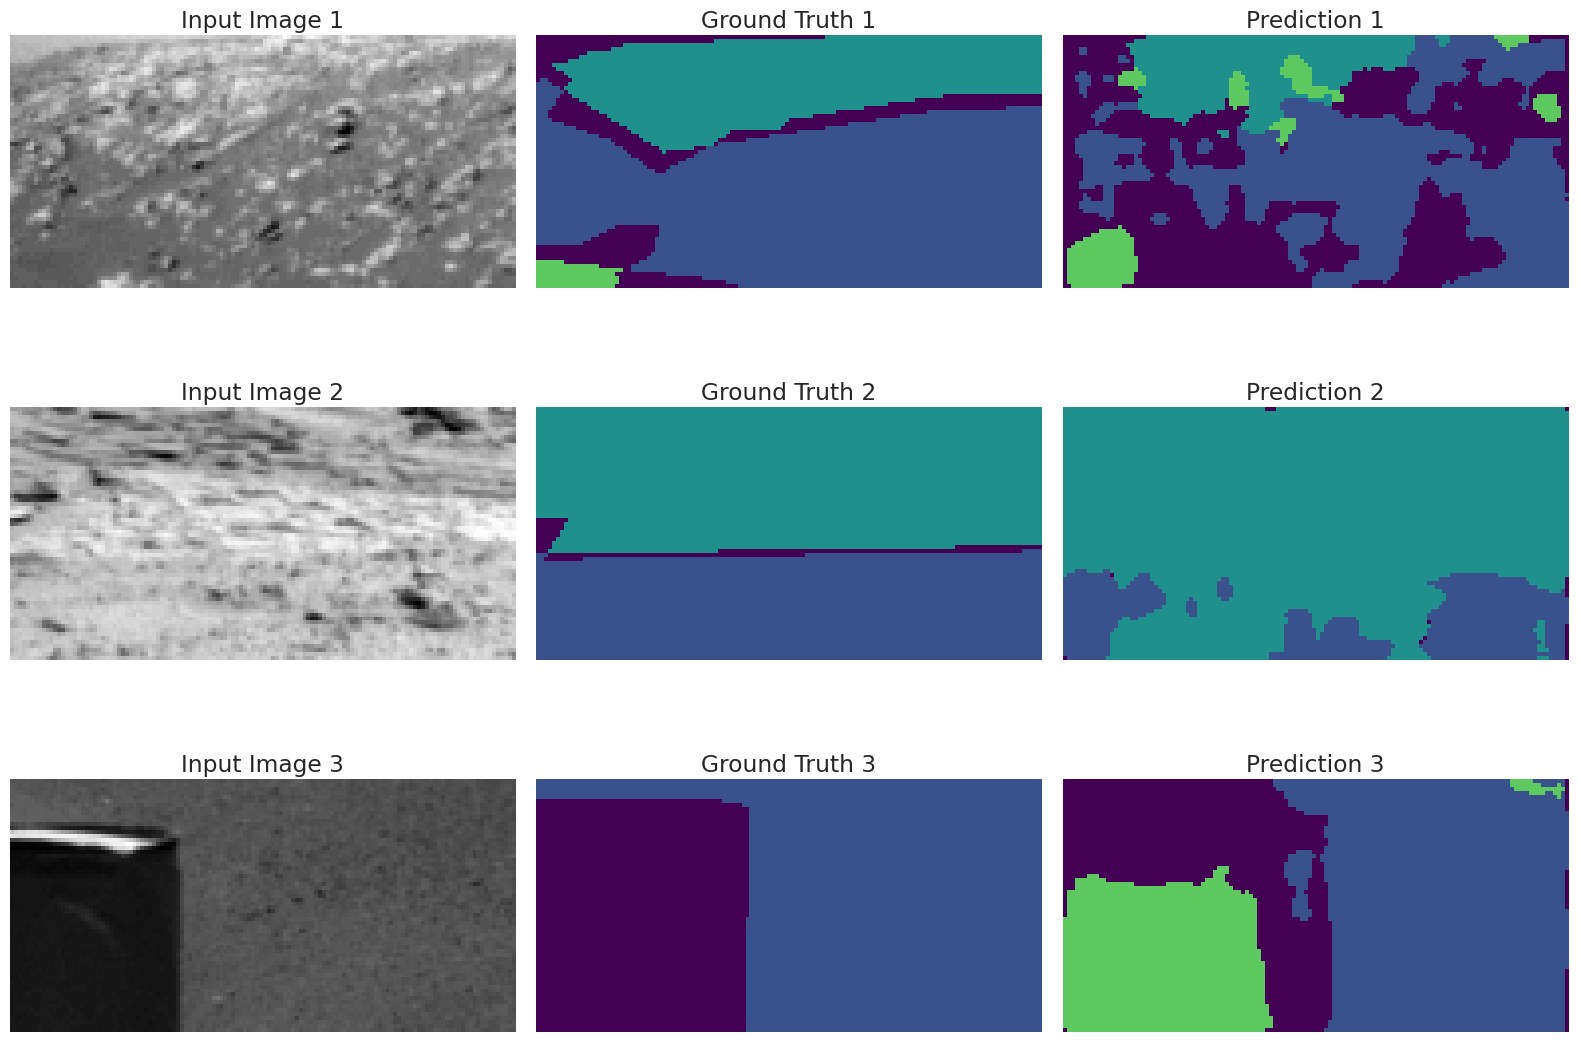

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8471 - loss: 0.4091 - mean_iou: 0.5310 - val_accuracy: 0.7660 - val_loss: 0.6250 - val_mean_iou: 0.4708 - learning_rate: 1.0000e-04
Epoch 42/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8495 - loss: 0.4031 - mean_iou: 0.5325 - val_accuracy: 0.7653 - val_loss: 0.6288 - val_mean_iou: 0.4722 - learning_rate: 1.0000e-04
Epoch 43/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8519 - loss: 0.3971 - mean_iou: 0.5340 - val_accuracy: 0.7644 - val_loss: 0.6320 - val_mean_iou: 0.4706 - learning_rate: 1.0000e-04
Epoch 44/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8544 - loss: 0.3910 - mean_iou: 0.5354 - val_accuracy: 0.7651 - val_loss: 0.6340 - val_mean_iou: 0.4724 - learning_rate: 1.0000e-04
Epoch 45/160
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8569 - loss: 0.3850 - mean_iou: 0.5367 - val_accuracy: 0.7616 - val_loss: 0.6440 - val_mean_iou: 0.4692 - learning_rate: 1.0000e-04
Final validation M

In [83]:
# Train the model
history = baseline.fit(
    X_train,
    y_train,
    epochs=epochs,
    callbacks=[earlystop, viz_callback, plateau],
    verbose=1,
    validation_data=(X_val, y_val)
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f'Flagship_{final_val_meanIoU}_{timestep_str}.keras'
baseline.save(model_filename)
del baseline

# Preparation of submission

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive

if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('THEHULK') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [84]:
# Manually set model name if you wish

model_filename = "Flagship_54.65_241214_172248.keras"
print(model_filename)

Flagship_54.65_241214_172248.keras


In [85]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from Flagship_54.65_241214_172248.keras


In [86]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step
Predictions shape: (10022, 64, 128)


In [87]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [88]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>